TODO:
- add a link to where in this book semiconductor RLCs are covered
- add a link to where tank filters are covered
- get a power engineer familiar with housing and 3phase to review this cause I am not one
- get the scales on the Delta circuit fixed and figure out the spike


In [1]:
#%%writefile AC_2_Codes.py
#Library import statements

from skidl.pyspice import *
#can you say cheeky 
import PySpice as pspice
#becouse it's written by a kiwi you know
import lcapy as kiwi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import YouTubeVideo, display

import traceback

In [2]:
from DC_1_Codes import get_skidl_spice_ref
#notebook specific loading control statements 
%matplotlib inline
#tool to log notebook internals
#https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information skidl, PySpice,lcapy, sympy, numpy, matplotlib, pandas, scipy

Software,Version
Python,3.7.6 64bit [GCC 7.3.0]
IPython,7.12.0
OS,Linux 4.19.104 microsoft standard x86_64 with debian bullseye sid
skidl,0.0.31.dev0
PySpice,1.4.3
lcapy,0.70
sympy,1.6.2
numpy,1.18.1
matplotlib,3.3.0
pandas,1.1.4


# Capacitors and Inductors

Now that we're in AC simulations SPICE no longer ignores capacitors and inductors as opens and shorts respectively. So real quick how do we invoke them in SKiDl. (note where focusing here on basic standard capacitors, not semiconductor RLCs which are going to get there own discussion further along in this chapter)
Recalling that to invoke a resistor 

```
#create dummy nets for demo
net_1=Net('N1); net_2=Net('N2')
#create the resistor
r1=R(ref='R1', value=1@u_Ohm)
#connect the resistor
r1[1, 2]+=net_1, net_2
```
that would yield a SPICE netlist statement of
```
R1 N1 N2 1Ohm
```
Where to be honest we could have let SKiDl taken care of the reference and omitted it when the resistor was instantiated. For capacitors and inductors, the procedure is the same

Capacitor:

```
#create dummy nets for demo
net_1=Net('N1); net_2=Net('N2')
#create the capacitor
c1=C(ref='C1', value=1@u_F)
#connect the capacitor
c1['p', 'n']+=net_1, net_2
```
that would yield a SPICE netlist statment of

```
C1 N1 N2 1F
```

Inductor: 
```
#create dummy nets for demo
net_1=Net('N1); net_2=Net('N2')
#create the inductor
l1=L(ref='L1', value=1@u_H)
#connect the inductor
l1['1', '2']+=net_1, net_2
```
that would yield a SPICE netlist statement of

```
L1 N1 N2 1H
```

So there is no real difference except for a major subtle detail of convention. Notice that the capacitor was connected to the netlist via a polarity port statement `c1['p', 'n']+=net_1, net_2`  whereas the resistor and inductor were connected with just numbering. While technically SKiDl doesn't care if we use numbers or named terminals as long as there a one-to-one mapping inside SKiDl (see the appendix adlkfjaldjkfkj and or look at [skidl/skidl/libs/pyspice_sklib.py](https://github.com/xesscorp/skidl/blob/master/skidl/libs/pyspice_sklib.py)) The reason for the difference is because ~99% of resistors in the world are unpolarized and ~90% of all inductor are also unpolarized. Whereas more than 50% of capacitors are polarized. And when you pass DC (or otherwise) in the reviser polarization of a capacitor you can degrade if  not let lose the magic black smoke as it were. (insert an image of popped and budged electrolytic caps ) So to prevent that in this book at least 

In this section, we are just going to start working with AC circuits in SPICE. And we're going to start simple, but with something that is very poorly talked about and this is multiphase power circuits. Where only going to be scratching the surface of how to simulate these types of circuits in SPICE. And more often than not a lot of these multiphase circuits are driving motors. So below we have a crud model of a single armature of induction motor from an [electronics StackOverflow  quarry](https://electronics.stackexchange.com/questions/234290/using-a-single-phase-induction-motor-equivalent-circuit-in-ltspice) that will work well enough for these demonstrations. As it turns out getting a macro model of an electrical motor is no small feet.

In [3]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section1 single_arm_mod class
#used as a test load for multiphasic power circuits in this section. 

class single_arm_mod():
    """
    holding class for SKiDl Package and lcapy schematic of a 
    inductor motor amatuer model from
    https://electronics.stackexchange.com/questions/234290/using-a-single-phase-induction-motor-equivalent-circuit-in-ltspice
    used as a test load for multiphase power circuits
    """
 
    @package
    def SKiDl_pack(P=Net(), N=Net()):
        """
        SkiDl package to create a single-phase inductive motor armature
        
        Terminals:
            P: Positive terminal
            N: Negative terminal
        
        Returns:
            returns a model based on Handbook of Electric Power Calculations, Third Edition
            By H. Wayne Beaty Section 6: SINGLE-PHASE MOTORS with values sourced
            from a stackexchange quarry (see docstring right under class)
        """
        
        #top loop elements
        l1=L(value=31.6/314@u_H)
        r1=R(value=0.8@u_Ohm)
        l2=L(value=4.34/314@u_H)
        r2=R(value=2.21/.005@u_Ohm)

        #bottom loop elements
        l3=L(value=31.6/314@u_H)
        r3=R(value=0.8@u_Ohm)
        l4=L(value=4.34/314@u_H)
        r4=R(value=2.21/.005@u_Ohm)

        #conect terminal loop
        P & l1['p', 'n']  & l3['p', 'n'] & N

        #connect top loop
        l1['p'] & r1 & l2 & r2 & l1['n']

        #connect bottom loop
        l3['p'] & r3 & l4 & r4 & l3['n']

    
    def draw_me():
        """
        Lcapy schematic of the SKiDl package in this class
        
        Returns:
            returns a model based on Handbook of Electric Power Calculations, Third Edition
            By H. Wayne Beaty Section 6: SINGLE-PHASE MOTORS with values sourced
            from a stackexchange quarry (see docstring right under class)
        """
        
        schematic=kiwi.Circuit()
        
        #termanl loop
        schematic.add('W P 1;right')
        schematic.add('L1 1 3; down')
        schematic.add('W 3 3_2; down')
        schematic.add('L3 3_2 2; down=0.5')
        schematic.add('W N 2;right')
        
        #top loop
        schematic.add('R1 1 4; right')
        schematic.add('L2 4 5; right')
        schematic.add('R2 5 3_1; down')
        schematic.add('W 3 3_1; right')
        
        #bottom loop
        schematic.add('R3 3_2 6; right')
        schematic.add('L4 6 7; right')
        schematic.add('R4 7 2_1; down')
        schematic.add('W 2 2_1; right=2')
        
        
        schematic.draw()


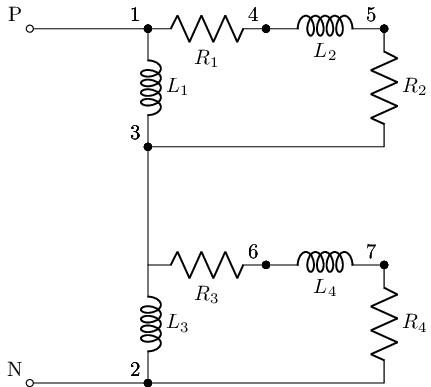

In [4]:
single_arm_mod.draw_me()

So starting off what is a SKiDl Package vs a SKiDl subcircuit that was introduced in the last chapter. SKiDl subcircuits are accessible collections of elements that we have real ease of manipulation which is why we will use subcircuits to build testbenchs. Whereas SKiDl packages are more static invoke packages more akin to so-called SPICE Macro models. Both of them allow one to create functions(methods) that have ports and have pass-through parameters to their invocation. But after the invoking of a package, the internal elements are not accessible outside of the package but do appear in the final Netlist.

Then the next thing to address is this use of classes. We use classes as a collected binding of interrelated variables (called attributes) and functions (called methods) that work together via the `self` keyword in a class. This allows us to keep the things in our code organized along with OOP for inheritance. Here we are just using a class as a storge item to hold our package and is easily invokable in python schematic of the partial circuit that the package generates.


# AC Sources 

So far we have talked about DC source as a separate entry and that is because SKiDl and PySpice treat them as separate entries but SPICE and specifically ngspice treat DC AC and most transient source as a single element and makes the distinction via the arguments. Lets then look at the ngspice statement for an independent source form section 4.1 [typical location in the ngspice manual] of
```
VXXXXXXX N+ N- <<DC> DC/TRAN VALUE > <AC <ACMAG <ACPHASE >>> <DISTOF1 <F1MAG <F1PHASE >>> <DISTOF2 <F2MAG <F2PHASE >>>
```
Where broken down `VXXXXXXX N+ N-` is the name of the source and it's two terminals. Next is `<<DC> DC/TRAN VALUE >` This is the DC source that we have been invoking with V( dc_value=) in SkiDl and PySpice. This is also where the transient simulation control statement goes, more on that in a second. Then we have 	`<AC <ACMAG <ACPHASE >>>`	 These are the .ac simulation parameters of a source. For now we will ignore 	`<DISTOF1 <F1MAG <F1PHASE >>> <DISTOF2 <F2MAG <F2PHASE >>>` for chapter lkadjfkj on distortion. But in addition to the above general statement, any independent source may have tagged onto it the transient simulation statement such as Sinusoidal, exponential, pulse, etc. Thus the PySpices and SKiDl authors compounded the DC AC and transient Sinusoidal source to one invocation in SkiDl and PySPice, the SINV & SINI souces. Where then all the other transient sources have their own invocation that will be discuses in the chapter on transient simulations. For this chapter what needs to be known is that linear independent DC voltage source is a subset of independent Sinusoidal sources that not only have the add .ac simulation values but also the transient simulation values. Thus the SINV statement is
```
skidl_SINV=SINEV(ref='1', 
            #transit sim statements
            offset=5,amplitude=5, frequency=5 , delay=5, damping_factor=5,
            #ac sim statements
            ac_phase=np.deg2rad(-90), ac_magnitude=5, 
            #dc outset for DC, AC, Transient simulations 
            dc_offset=5)
```
resulting in
```
V1 N1 N2 DC 5V AC 5V -90.0rad SIN(5V 5V 5Hz 5s 5Hz)
```
and similarly SINI is
```
skidl_SINI=SINEI(ref='1', 
            #transit sim statements
            offset=5,amplitude=5, frequency=5 , delay=5, damping_factor=5,
            #ac sim statements
            ac_phase=np.deg2rad(-90), ac_magnitude=5, 
            #dc outset for DC, AC, Transient simulations 
            dc_offset=5)
```
```
I1 N1 N2 DC 5A AC 5A -90.0rad SIN(5A 5A 5Hz 5s 5Hz)
```
[ the argument `ac_phase=np.deg2rad(-90)` is experimental and has to be provided in rads but converts to deg internal but is reported in rad, hence why it's experimental due to the unit u_deg outputting to Celsius ]

In this chapter, we will only focus on the arguments `ac_phase`, `ac_magnitude`, `dc_offset`, and will deal with the transient control argument in the transient simulation chapter. Also, linear dependent sources do not need anything special done to them for .ac simulations or any other simulation for that matter since they merely read in a signal and apply a scaled output of the instantaneous single applied to the control side.
Also note that Voltage sources can not be put into parallel in inductors and the same goes for current sources and capacitors, without inciting a singular matrix error in spice. The remedy is to add a 0ohm series resistor between the source and the field element.


# $V_{max}$,  Fourier terms, and RMS¶
For a recollection of what RMS values and how they relate to max value see ALL ABOUT ELECTRONICS YT video ["RMS (Root Mean Square) Value and Average Value of AC Signals"](https://youtu.be/qDHsokTcgck)


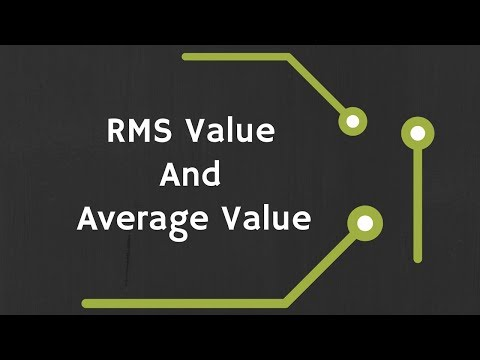

In [5]:
YouTubeVideo('qDHsokTcgck', width=500, height=400, )

For now, just understand that .ac simulation returns max value per frequency which is the same as the Fourier values.

# Single Phase Cirucit

For modeling a single spice circuit we need only have all our sources have that same value of ac_phase. Here we will just use a single source in parral with our inductive motor armature to see how a .ac simulation works.

In [6]:
reset()

#create a sine source with max 120V
vs=SINEV(ac_magnitude=120@u_V)
#branch loop issue, neet dummy resistor to fix singularity
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd

#create and hook up the inductive motor armature
arm1=single_arm_mod.SKiDl_pack(); arm1['P', 'N']+=rdummy[2], gnd

circ=generate_netlist()
print(circ)


.title 
L1 N_2 N_4 0.10063694267515924H
L2 N_5 N_6 0.013821656050955413H
L3 N_4 0 0.10063694267515924H
L4 N_7 N_8 0.013821656050955413H
R2 N_2 N_5 0.8Ohm
R3 N_6 N_4 442.0Ohm
R4 N_4 N_7 0.8Ohm
R5 N_8 0 442.0Ohm
V1 N_1 0 DC 0V AC 120V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Rdummy N_1 N_2 0Ohm




No errors or warnings found during netlist generation.



In [7]:
#create sim
sim=circ.simulator()
#run an ac sim from 48 to 62 Hz linearly over 100 data points
ac_vals=sim.ac(start_frequency=48@u_Hz, stop_frequency=62@u_Hz, number_of_points=100, variation='lin')

One should have noticed that for the source since we intend to use it purely for .ac simulations no frequency of the source we specified. This is because of how .ac simulations work. First, an operating point simulation is done to linearize any nonlinear sources (we will talk about this at length in later chapters when we start working with nonlinear devices). Next, the starting frequency is set to all sinusoidal sources, where non-sinusoidal sources are ignored via their respective means. Then the circuit’s response to the first applied frequency is recorded. Then the simulation moves on to the next simulation frequency and repeats. The recoded results are sinusoids given in terms of complex representation. Thus what an ac simulation is doing from a signals and systems point of view is sampling the Fourier space response of a linearized version of the circuit under test. Thus the arguments for the ac simulation’s `start_frequency`(inclusive and non-inclusive) and `stop_frequency`( non-inclusive) set the lower and upper bound of the circuit Fourier space that the .ac simulation is going to look through. Then number_of_points tells the simulation how many points to sample in accordance with the sampling scheme set by `variation`. We will discuss the other sampling schemes in the next section but for this section will stick with linear where the starting frequency is inclusive so that frequency samples are the same as `np.linspace`

The results are returned in the same manner as when using .dc expect we replace the .sweep in the return of .dc with .frequnacy in a .ac simulation as shown below

In [8]:
#store the results in a dataframe
#store the frequency to the index
ac_data_base_df=pd.DataFrame(index=ac_vals.frequency.as_ndarray())
#name the index
ac_data_base_df.index.name='freq[Hz]'
#store the voltage at the positive side of the source
ac_data_base_df['Source_v_[V]']=ac_vals[node(rdummy[2])].as_ndarray()
#store the current from the source
ac_data_base_df['Source_i_[A]']=-ac_vals['V1'].as_ndarray()

ac_data_base_df

,Source_v_[V],Source_i_[A]
freq[Hz],,
48.000000,119.999863+0.001978j,0.135522-1.978116j
48.141415,119.999863+0.001972j,0.135522-1.972313j
48.282829,119.999863+0.001967j,0.135521-1.966544j
48.424244,119.999863+0.001961j,0.135521-1.960809j
48.565655,119.999863+0.001955j,0.135521-1.955107j
...,...,...
61.434345,119.999863+0.001546j,0.135501-1.546182j
61.575756,119.999863+0.001543j,0.135501-1.542638j
61.717171,119.999863+0.001539j,0.135501-1.539111j


As we see these are complex values representing the frequency response of 120V sinusoid with frequency controlled by the ac simulation. And thus, we naively plot them we will have issues with matplotlib not knowing how to interpret complex values thusly.

/home/iridium/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/iridium/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


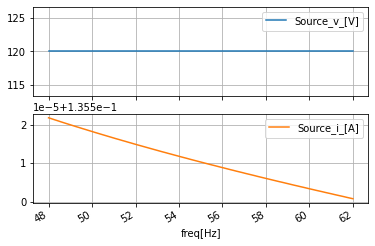

In [9]:
#quick plot of the voltage and current vs the frequency
#since the values are Fourier terms there going to be complex
ac_data_base_df.plot(subplots=True, sharex=True, grid=True);

Thus, to analyze these Fourier components we need to decode the information contained in the complex sinusoid representation. We start by looking at the magnitude representation achieved by applying `np.abs` below

,Source_v_[V],Source_i_[A]
freq[Hz],,
48.000000,119.999863,1.982753
48.141415,119.999863,1.976964
48.282829,119.999863,1.971208
48.424244,119.999863,1.965486
48.565655,119.999863,1.959798
...,...,...
61.434345,119.999863,1.552108
61.575756,119.999863,1.548578
61.717171,119.999863,1.545064


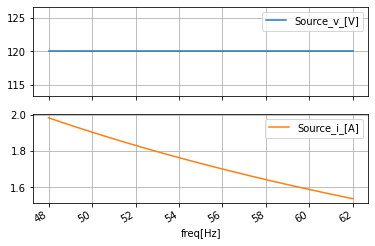

In [10]:
#make a magnitude version of the data and plot it
ac_data_mag_df=ac_data_base_df.apply(np.abs, axis=0)
ac_data_mag_df.plot(subplots=True, sharex=True, grid=True);
ac_data_mag_df

Thus, showing that the linear dependent voltage source is indeed holding the proper voltage of 120V regardless of the frequency but that the current being drawn from the source is a function of the operating frequency. And for this section, the simulation frequency is chosen to represent a sweep through $\pm2$Hz of the two major power gid operating frequency of 50 and 60 Hz.

Next, we look at the phase information in terms of radians, where radians are seldom used in power analysis. We do this via `np.angle`


,Source_v_[V],Source_i_[A]
freq[Hz],,
48.000000,0.000016,-1.502393
48.141415,0.000016,-1.502192
48.282829,0.000016,-1.501992
48.424244,0.000016,-1.501791
48.565655,0.000016,-1.501591
...,...,...
61.434345,0.000013,-1.483383
61.575756,0.000013,-1.483184
61.717171,0.000013,-1.482984


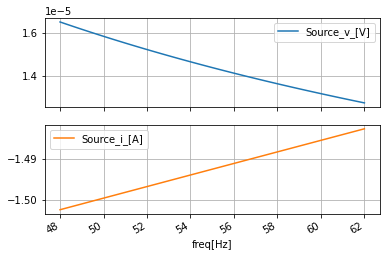

In [11]:
#look at the phase in terms of rads; not typically done in power
ac_data_degrad_df=ac_data_base_df.apply(np.angle, axis=0)
ac_data_degrad_df.plot(subplots=True, sharex=True, grid=True);
ac_data_degrad_df


We can look at the same thing in terms of degrees by adding the argument `deg=True` to `np.angle`

,Source_v_[V],Source_i_[A]
freq[Hz],,
48.000000,0.000944,-86.080757
48.141415,0.000942,-86.069267
48.282829,0.000939,-86.057793
48.424244,0.000936,-86.046303
48.565655,0.000933,-86.034813
...,...,...
61.434345,0.000738,-84.991608
61.575756,0.000737,-84.980179
61.717171,0.000735,-84.968735


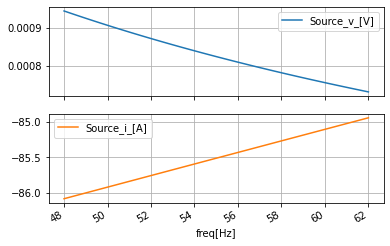

In [12]:
#look at the phase in degrees
ac_data_degang_df=ac_data_base_df.apply(np.angle, axis=0, deg=True)
ac_data_degang_df.plot(subplots=True, sharex=True, grid=True);
ac_data_degang_df

This shows that there is some slight phase in the voltage with respect to the ground. But this is mostly numerical issues. What is mostly happening is that the current is lagging the voltage at the ground from 86 to 85 degrees. This is  obvious given that the load is fully resistive inductive.

There is one more representation of the phase and that is phase unwrapped. This most for other simulations in this chapter but we will discuss it here. When using np.deg in degrees it will cycle back on itself every 360 degrees. We don't get this in the radian interpretation. Thus, we have also have phase degree unwrapped which accumulates the angle phase to that its value can go beyond 360 degrees. Here it doesn't do us much good but in the next sections, this view will become extremely important.


In [13]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section1 angle_phase_unwrap lambda function
#lambda function to find the unwrapped phase from complex values 

angle_phase_unwrap= lambda x: np.rad2deg(np.unwrap(np.angle(x)))


,Source_v_[V],Source_i_[A]
freq[Hz],,
48.000000,0.000944,-86.080758
48.141415,0.000942,-86.069270
48.282829,0.000939,-86.057788
48.424244,0.000936,-86.046300
48.565655,0.000933,-86.034811
...,...,...
61.434345,0.000738,-84.991609
61.575756,0.000737,-84.980175
61.717171,0.000735,-84.968735


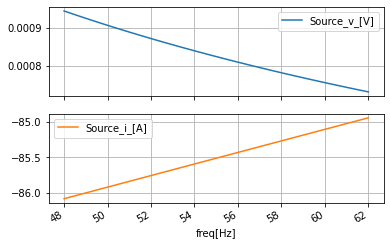

In [14]:
#look at the phase in degrees unwrapped, since the phase here did not go
#beyond 2pi doesn't do anything
ac_data_deganguw_df=ac_data_base_df.apply(angle_phase_unwrap, axis=0)
ac_data_deganguw_df.plot(subplots=True, sharex=True, grid=True);
ac_data_deganguw_df


## Power Measurments¶
Since with SPICE we have access to current and voltage and with Python we have a better claualtor then pretty much any SPICE utlity ever lets make some tooling to find all the typical power terms:

- the instaniues power: $p[W]=v \cdot i [V \cdot A]$

- the averge or avtive Power: $P[W]=\dfrac{\Re( v \cdot i^*)}{2} [V \cdot A]$

- the reactive power: $Q[VAR]=\dfrac{\Im( v \cdot i^*)}{2} [V \cdot A]$

- the complex power: $S[VAR]=\dfrac{ v \cdot i^*}{2} [V \cdot A]$

- the apparent power: $s[VAR]=\left| \dfrac{ v \cdot i^*}{2} \right| [V \cdot A]$

- the power factor: $pf[]=\dfrac{P}{s} [W/VA]$

- the power factor angle: $\phi_{pf}[deg/rad]=\arccos\left(\dfrac{P}{s}\right) [W/VA]$

- the parrel compentions capcitor value per frequancy: $C[F]=\frac{2 P \cdot \left( \tan{\left(\theta_{i} \right)} - \tan{\left(\theta_{f} \right)}\right)}{\omega |V|^{2}}$

- the parrel compentions inductor value per frequancy: $L[H]= \frac{|V|^{2}}{2 P \cdot \omega \left( \tan{\left(\theta_{i} \right)} - \tan{\left(\theta_{f} \right)}\right)} $

For a refresher on most of these terms ALL ABOUT ELELECTINCS YT video ["What is Power Factor? What is Leading & Lagging Power factor ? Power Factor Correction Methods"](https://youtu.be/iDYWfBGwT1w)


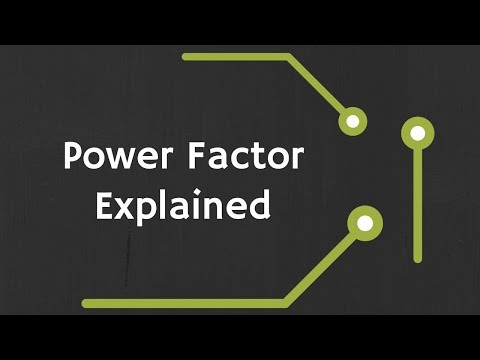

In [15]:
YouTubeVideo('iDYWfBGwT1w', width=500, height=400, )

### Complex power and an E&M side note¶
The reactive power Q is often treated as a fictitious power term; It's not. Poynting's theorem, that theorem that defines photon power in classical E&M is $$-\oint_{S} (E \times H) \cdot dS=\iiint_{V} \left[ \dfrac{\mu}{2}\dfrac{\partial|H|^2}{\partial t} +\dfrac{\epsilon}{2}\dfrac{\partial|E|^2}{\partial t} + E\cdot J \right]dV $$ Where recalling that Poynting's theorem is also about power flux for E&M filds we can break it down to

- $-\oint_{S} (E \times H) \cdot dS$ = the complex power $S$, aka the full elemtromatic power inclosed in a volume

- $\iiint_{V} E\cdot J dV$ = the average or active power $P$ this is the dissipative power aka the ohmic power

- $\iiint_{V} \left[ \dfrac{\mu}{2}\dfrac{\partial|H|^2}{\partial t} +\dfrac{\epsilon}{2}\dfrac{\partial|E|^2}{\partial t} \right] dV$ is the reactive poewr $Q$, or the power stored in the E & M fields. Wich are physical empoided by captiors and inductors in our circuits.

One of the consequences of this is that the power factor tells us is whether the E field or the M field is containing the majority of the reactive power.

With respect to a periodic steady-state signal like a sinusoid, it is true that the time average of the reactive power is zero. But as All ABOUT ELELCTROINCS showed what is happening during the period is that the power in the field is being pulled from the source during the first half of the period and then returned to the source in the second half. In other words, the reactive power is sloshing back and forth. This is not a good thing, especially at the source. So what we do is add a compensating reciprocal element to bring the power factor to close to zero. Wich is the same as saying that an LC oscillator is created so that the reactive power sloshing about is in a local tank (parrel LC elements are also called tank circuits) instead of with the whole circuit. Also if anyone says reactive power is fictitious ask why we then need flyback diodes on inductors. Cause I can ensure you a driving sinusoid is removed from the circuit the reactive power stored in the inductor will very quickly become active power in the circuit if not compensated for.


In [16]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section1 power_calcs_ac class
#class to store power calculations and aid functions as staticmethods

class power_calcs_ac():
    """
    Because I am too lazy to create one that works with time
    based data as well this only works with the .ac Fourier like data
    """
    
    @staticmethod
    def instantaneous_power_calc(voltage, current):
        """
        Staticmethod to compute the instantaneous power: 
        $$p[W]=v \cdot i [V \cdot A]$$
        
        Args:
            voltage (np.float or np.complex array): the voltage in terms of 
                Fourier terms whose length must match the `current` argument
            
            current (np.float or np.complex array): the current in terms of 
                Fourier terms whose length must match the `voltage` argument
        Returns:
            returns an array with the so-called instantaneous power in Watts
        
        """
        return voltage*current
                               
    
    @staticmethod
    def averge_power_calc(voltage, current):
        """
        Staticmethod to compute the so-called average power: 
        $$P[W]=\dfrac{\Re( v \cdot i^*)}{2} [V \cdot A]$$
        
        Args:
            voltage (np.float or np.complex array): the voltage in terms of 
                Fourier terms whose length must match the `current` argument
            
            current (np.float or np.complex array): the current in terms of 
                Fourier terms whose length must match the `voltage` argument
        Returns:
            returns an array with the so-called average power in Watts
        
        """
        Power=voltage*np.conj(current)
        Power=np.real(Power)/2
        return Power
    
    @staticmethod
    def reactive_power_calc(voltage, current):
        """
        Staticmethod to compute the so-called reactive power: 
        $$Q[VAR]=\dfrac{\Im( v \cdot i^*)}{2} [V \cdot A]$$
        
        Args:
            voltage (np.float or np.complex array): the voltage in terms of 
                Fourier terms whose length must match the `current` argument
            
            current (np.float or np.complex array): the current in terms of 
                Fourier terms whose length must match the `voltage` argument
        Returns:
            returns an array with the so-called reactive power in Volt-Ampere Reactive [VAR]
        
        """
        Qpower=voltage*np.conj(current)
        Qpower=np.imag(Qpower)/2
        return Qpower
    
    @staticmethod
    def complex_power_calc(voltage, current):
        """
        Staticmethod to compute the so-called complex power: 
        $$S[VA]=\dfrac{ v \cdot i^*}{2}  [V \cdot A]$$
        
        Args:
            voltage (np.float or np.complex array): the voltage in terms of 
                Fourier terms whos length must match the `current` argument
            
            current (np.float or np.complex array): the current in terms of 
                Fourier terms whose length must match the `voltage` argument
        Returns:
            returns an array with the so-called apparent power in Volt-Ampere [VA]
        
        """
        Spower=voltage*np.conj(current)
        Spower=Spower/2
        return Spower
    
    @staticmethod
    def apparent_power_calc(voltage, current):
        """
        Staticmethod to compute the so-called apparent power: 
        $$S[VA]=\left| \dfrac{ v \cdot i^*}{2} \right| [V \cdot A]$$
        
        Args:
            voltage (np.float or np.complex array): the voltage in terms of 
                Fourier terms whose length must match the `current` argument
            
            current (np.float or np.complex array): the current in terms of 
                Fourier terms whose length must match the `voltage` argument
        Returns:
            returns an array with the so-called complex power in Volt-Ampere [VA]
        
        """
        Spower=power_calcs_ac.complex_power_calc(voltage, current)
        spower=np.abs(Spower)
        return spower
    
    @staticmethod
    def power_factor_calc(voltage, current):
        """
        Staticmethod to compute the so-called power factor via: 
        $$pf[]=\dfrac{P}{s} [W/VA]$$
        
        Args:
            voltage (np.float or np.complex array): the voltage in terms of 
                Fourier terms whos length must match the `current` argument
            
            current (np.float or np.complex array): the current in terms of 
                Fourier terms whose length must match the `voltage` argument
        Returns:
            returns an array with the so-called power factor that is unitless 
        
        """
        Ppower=power_calcs_ac.averge_power_calc(voltage, current)
        spower=power_calcs_ac.apparent_power_calc(voltage, current)
        pf=Ppower/spower
        return pf
    
    @staticmethod 
    def power_factor_angle_calc(voltage, current, deg=True):
        """
        Staticmethod to compute the so-called power factor angle via: 
        $$\phi_{pf}[deg/rad]=\arccos\left(\dfrac{P}{s}\right) [W/VA]$$
        
        Args:
            voltage (np.float or np.complex array): the voltage in terms of 
                Fourier terms whose length must match the `current` argument
            
            current (np.float or np.complex array): the current in terms of 
                Fourier terms whose length must match the `voltage` argument
            
            deg (bool; True): When True returns the power factor angle in degrees, else in radians
                
        Returns:
            returns an array with the so-called power factor angle in degrees when `deg` is true, else in radians
        
        """
        pf=power_calcs_ac.power_factor_calc(voltage, current)
        pf_ang=np.arccos(pf)
        
        if deg:
            pf_ang=np.rad2deg(pf_ang)
            
        
        return pf_ang
    
    @staticmethod
    def Cparallel_comp(new_pf_ang, voltage, current, frequancy):
        """
        Statcmethod to calculate the parallel compensating capacitor for inductive loads
        based on the following equation
        
        $$ C[F]=\frac{2 P \cdot \left( \tan{\left(\theta_{i} \right)} - \tan{\left(\theta_{f} \right)}\right)}{\omega |V|^{2}} $$

        
        Args:
            new_pf_ang (float; deg):new power factor angle goal
            
            voltage (np.float or np.complex array): the voltage in terms of 
                Fourier terms whose length must match the `current` argument
            
            current (np.float or np.complex array): the current in terms of 
                Fourier terms whose length must match the `voltage` argument
            
            frequency (np.float): the frequencies matching the current and voltage arrays
                
        Returns:
            returns an array with the needed compensation to reach the target power factor in Farads 
        
        """
        Power=power_calcs_ac.averge_power_calc(voltage, current)
        int_pf_ang=power_calcs_ac.power_factor_angle_calc(voltage, current)
        deltaQ=Power*(np.tan(np.deg2rad(int_pf_ang))-np.tan(np.deg2rad(new_pf_ang)))
        Vmag=np.abs(voltage)
        angfreq=2*np.pi*frequancy
        
        C=(2*deltaQ)/(angfreq*Vmag**2)
        
        return C
    
    @staticmethod
    def Lparallel_comp(new_pf_ang, voltage, current, frequancy):
        
        """
        Statcmethod to calculate the parallel compensating inductor for capacitive loads
        based on the following equation
        
        $$L[H]= \frac{|V|^{2}}{2 P \cdot \omega \left( \tan{\left(\theta_{i} \right)} - \tan{\left(\theta_{f} \right)}\right)} $$
        
        Args:
            new_pf_ang (float; deg):new power factor angle goal
            
            voltage (np.float or np.complex array): the voltage in terms of 
                Fourier terms whos length must match the `current` argument
            
            current (np.float or np.complex array): the current in terms of 
                Fourier terms whose length must match the `voltage` argument
            
            frequency (np.float): the frequencies matching the current and voltage arrays
                
        Returns:
            returns an array with the needed compensation to reach the target power factor in Henrys 
        
        """
        
        Power=power_calcs_ac.averge_power_calc(voltage, current)
        int_pf_ang=power_calcs_ac.power_factor_angle_calc(voltage, current)
        deltaQ=Power*(np.tan(np.deg2rad(int_pf_ang))-np.tan(np.deg2rad(new_pf_ang)))
        Vmag=np.abs(voltage)
        angfreq=2*np.pi*frequancy
        
        L=(Vmag**2)/(2*angfreq*deltaQ)
        
        return L
    
    
    @staticmethod
    def autogen_powercalcs(source_dataframe, base_term):
        """
        Static method to automatically calculate and add the dataframe the 
        instantaneous_power_calc, averge_power_calc, reactive_power_calc, complex_power_calc, apparent_power_calc, 
        power_factor_calc power_factor_angle_calc methods in this class
        
        Args:
            source_dataframe (pandas.dataframe): pandas dataframe containing the AC frequencies 
                in the index, columns in the forms of  `<base_term>_v_[V]` and `<base_term>_i_[A]`
            
            base_term (string): the based string as part of the column names of 
                `<base_term>_v_[V]` and `<base_term>_i_[A]`
                that are the source columns that will be sourced to calculate the other measurements
                
        Returns:
            adds the following:
            source_dataframe[f'{base_term}_p_[W]'], source_dataframe[f'{base_term}_P_[W]'], source_dataframe[f'{base_term}_Q_[VAR]']
            source_dataframe[f'{base_term}_S_[VA]'] ,source_dataframe[f'{base_term}_s_[VA]'], source_dataframe[f'{base_term}_pf_[]'], 
            source_dataframe[f'{base_term}_pfang_[deg]']
            
        
        """
        voltage_col=source_dataframe[f'{base_term}_v_[V]']; current_col=source_dataframe[f'{base_term}_i_[A]']
        
        source_dataframe[f'{base_term}_p_[W]']=power_calcs_ac.instantaneous_power_calc(voltage_col, current_col)
        source_dataframe[f'{base_term}_P_[W]']=power_calcs_ac.averge_power_calc(voltage_col, current_col)
        source_dataframe[f'{base_term}_Q_[VAR]']=power_calcs_ac.reactive_power_calc(voltage_col, current_col)
        source_dataframe[f'{base_term}_S_[VA]']=power_calcs_ac.complex_power_calc(voltage_col, current_col)
        source_dataframe[f'{base_term}_s_[VA]']=power_calcs_ac.apparent_power_calc(voltage_col, current_col)
        source_dataframe[f'{base_term}_pf_[]']=power_calcs_ac.power_factor_calc(voltage_col, current_col)
        source_dataframe[f'{base_term}_pfang_[deg]']=power_calcs_ac.power_factor_angle_calc(voltage_col, current_col)
    
    @staticmethod
    def make_power_plot(source_dataframe, base_term, frequncy_scale='linear'):
        """
        Staticmethod to assist in the rapid plot creation of the three common
        AC powers and the power factor angle in a single 2x2 subplot
        
        Args:
            source_dataframe (pandas.dataframe): pandas dataframe containing the AC frequencies 
                in the index, columns in the forms of 
                `<base_term>_P_[W]`, `<base_term>_Q_[VAR]`, `<base_term>_s_[VA]`, `<base_term>_pfang_[deg]`
            
            base_term (string): the based string as part of the column names of 
                `<base_term>_P_[W]`, `<base_term>_Q_[VAR]`, `<base_term>_s_[VA]`, `<base_term>_pfang_[deg]`
                that are the source columns that create the plot
            
            frequncy_scale (string; 'linear'): the frequency scale that that data was collected against, must
                be `linear` for a linear ac sweep or `decade` for a logarithm decade collection that will make the
                plot be semilogx
        
        Returns:
            creates a 2x2 plot fo the power terms 
            
        TODO:
            -add octave scale
            -make plot generation cleaner between the different frequency scales
            -make the pf_deg work for rad as well
            -make it work with dataframes missing power terms, have it make
                them on the fly
            
        """
        assert frequncy_scale in ['linear', 'decade'], 'frequncy_scale must be linear or decade'
        
        fig, [[Pplot, Qplot], [splot, pfangplot]]=plt.subplots(nrows=2, ncols=2, sharex=True)
        plots=[Pplot, Qplot, splot, pfangplot]
        x=source_dataframe.index
        x_label=source_dataframe.index.name
        
        if frequncy_scale=='linear':
            
            if f'{base_term}_P_[W]' in source_dataframe.columns:
                Pplot.plot(x, source_dataframe[f'{base_term}_P_[W]'])

            if f'{base_term}_Q_[VAR]' in source_dataframe.columns:
                Qplot.plot(x, source_dataframe[f'{base_term}_Q_[VAR]'])

            if f'{base_term}_s_[VA]' in source_dataframe.columns:
                splot.plot(x, source_dataframe[f'{base_term}_s_[VA]'])

            if f'{base_term}_pfang_[deg]' in source_dataframe.columns:
                pfangplot.plot(x, source_dataframe[f'{base_term}_pfang_[deg]'])
        
        elif frequncy_scale in ['decade']:
            if f'{base_term}_P_[W]' in source_dataframe.columns:
                Pplot.semilogx(x, source_dataframe[f'{base_term}_P_[W]'])

            if f'{base_term}_Q_[VAR]' in source_dataframe.columns:
                Qplot.semilogx(x, source_dataframe[f'{base_term}_Q_[VAR]'])

            if f'{base_term}_s_[VA]' in source_dataframe.columns:
                splot.semilogx(x, source_dataframe[f'{base_term}_s_[VA]'])

            if f'{base_term}_pfang_[deg]' in source_dataframe.columns:
                pfangplot.semilogx(x, source_dataframe[f'{base_term}_pfang_[deg]'])
        
        #set the ylabels
        Pplot.set_ylabel('P_[W]')
        Qplot.set_ylabel('Q_[VAR]')
        splot.set_ylabel('s_[VA]')
        pfangplot.set_ylabel('pf_ang_[deg]')
        
        #set the xlabel, ticklabel controls, grid for all the subplots
        for plot in plots:
            plot.set_xlabel(x_label)
            plot.ticklabel_format(useOffset=False, axis='y')
            plot.grid()
        
        
        fig.suptitle(f'"{base_term}" power plots')
        plt.tight_layout()
        


In [17]:
#make a seperate dataframe to stowe power values in
ac_data_power_df=ac_data_base_df.copy()
ac_data_power_df.columns

Index(['Source_v_[V]', 'Source_i_[A]'], dtype='object')

With all the power calculation that are typically needed stowed away with handy utility methods to automate using them and plotting results lets put them to work

In [18]:
#make the power calculations
power_calcs_ac.autogen_powercalcs(ac_data_power_df, 'Source')
ac_data_power_df.columns
ac_data_power_df.head()

,Source_v_[V],Source_i_[A],Source_p_[W],Source_P_[W],Source_Q_[VAR],Source_S_[VA],Source_s_[VA],Source_pf_[],Source_pfang_[deg]
freq[Hz],,,,,,,,,
48.000000,119.999863+0.001978j,0.135522-1.978116j,16.266512-237.373428j,8.129342,118.686989,8.129342+118.686989j,118.965065,0.068334,86.081703
48.141415,119.999863+0.001972j,0.135522-1.972313j,16.266457-236.677048j,8.129339,118.338799,8.129339+118.338799j,118.617691,0.068534,86.070206
48.282829,119.999863+0.001967j,0.135521-1.966544j,16.266403-235.984772j,8.129333,117.992645,8.129333+117.992645j,118.272354,0.068734,86.058716
48.424244,119.999863+0.001961j,0.135521-1.960809j,16.266350-235.296524j,8.129330,117.648521,8.129330+117.648521j,117.929047,0.068934,86.047234
48.565655,119.999863+0.001955j,0.135521-1.955107j,16.266294-234.612274j,8.129325,117.306396,8.129325+117.306396j,117.587738,0.069134,86.035744


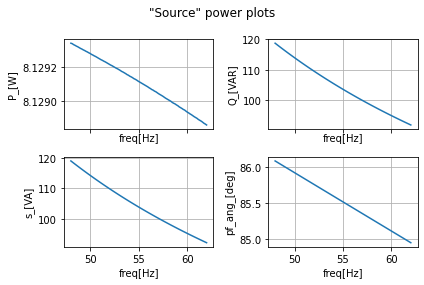

In [19]:
#make the plot of the power and power factor angle
power_calcs_ac.make_power_plot(ac_data_power_df, 'Source')

As can be seen, our power factor is clearly inductive and motor armature has a huge reactive power. Meaning that it is sourcing and returning a lot of energy in the inductor armature inductors and source.

## Single Phase Circuit with Capacitive Compensation¶
As we saw the super inductiveness of this circuit means that armature is drawing sloshing a lot of energy to and from the circuit. We compensate for that by adding a parallel capacitor to the amateur. This capacitor buffers the sloshing from the source once the circuit has settled down into a steady state. So that the inductors are building up their magnetic field they are sourcing that energy from the capacitor, and similarly when the inductor's magnetic fields are collapsing and sourcing power to the shunt capacitor. This sloshing is known as resonance and will be looked at more closely in the next section and the next chapter.

One of the calculation tools that was added to `power_calcs_ac` was `Cparallel_comp` that calculated the needed parallel capacitance given a new target power factor angle. For the most part, the ideal power factor is zero.


mean cap at mean freq:4.291683e-05[F]@55.0Hz


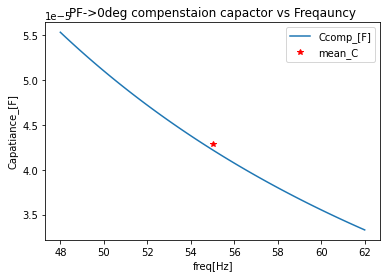

In [20]:
#find the compensation capacitance for each freq in the sweep
ac_data_power_df['Ccomp_[F]']=power_calcs_ac.Cparallel_comp(-10, ac_data_power_df['Source_v_[V]'],  ac_data_power_df['Source_i_[A]'], ac_data_power_df.index)
#get the mean value of the capacitor and where that mean frequency is
#dont do this in real life you will see why
ccomp_value=ac_data_power_df['Ccomp_[F]'].mean()
mean_freq=ac_data_power_df.index.values.mean()
print(f'mean cap at mean freq:{ccomp_value:2e}[F]@{mean_freq}Hz')

#make a plot of the compensation capacitance and the found mean
fig, ax = plt.subplots()
ac_data_power_df.plot(y='Ccomp_[F]', ax=ax)
ax.set_ylabel('Capatiance_[F]')
ax.plot(mean_freq, ccomp_value, '*r', label='mean_C')
ax.legend()
plt.title('PF->0deg compenstaion capactor vs Freqauncy');


What we see is that the capacitance need is a function of the frequency and has a fairly large range just within the span of 24Hz. Since we are staying basic here let's just pick the average capacitance as the shunt compensation capacitance value to use and repeat the simulation and analysis to see what happens.

In [21]:
#resimulat the circuit but now with the shunt compensation capacitance
reset()

vs=SINEV(ac_magnitude=120@u_V)
#branch loop issue, neet dummy resistor to fix singularly
rdummy=R(ref='dummy', value=0@u_Ohm)
vs['p', 'n']+=rdummy[1], gnd

#compansating capacitor 
ccomp=C(ref='comp', value=ccomp_value@u_F); ccomp['p', 'n']+=rdummy[2], gnd

arm1=single_arm_mod.SKiDl_pack(); arm1['P', 'N']+=ccomp['p'], gnd

circ=generate_netlist()
print(circ)


.title 
L1 N_2 N_5 0.10063694267515924H
L2 N_6 N_7 0.013821656050955413H
L3 N_5 0 0.10063694267515924H
L4 N_8 N_9 0.013821656050955413H
R2 N_2 N_6 0.8Ohm
R3 N_7 N_5 442.0Ohm
R4 N_5 N_8 0.8Ohm
R5 N_9 0 442.0Ohm
V1 N_1 0 DC 0V AC 120V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
Ccomp N_2 0 4.2916828429243215e-05
Rdummy N_1 N_2 0Ohm




No errors or warnings found during netlist generation.



In [22]:
#repreform the sim
sim=circ.simulator()
ac_vals=sim.ac(start_frequency=48@u_Hz, stop_frequency=62@u_Hz, number_of_points=100, variation='lin')

In [23]:
#recoloect the VI data
ac_data_base_df=pd.DataFrame(index=ac_vals.frequency.as_ndarray())
ac_data_base_df.index.name='freq[Hz]'
ac_data_base_df['Source_v_[V]']=ac_vals[node(rdummy[2])].as_ndarray()
ac_data_base_df['Source_i_[A]']=-ac_vals['V1'].as_ndarray()
#ac_data_base_df['Source_p_[W]']=ac_data_base_df['Source_v_[V]']*ac_data_base_df['Source_i_[A]']

ac_data_base_df

,Source_v_[V],Source_i_[A]
freq[Hz],,
48.000000,119.999863+0.000425j,0.135491-0.424911j
48.141415,119.999863+0.000415j,0.135491-0.414532j
48.282829,119.999863+0.000404j,0.135490-0.404186j
48.424244,119.999863+0.000394j,0.135490-0.393875j
48.565655,119.999863+0.000384j,0.135490-0.383597j
...,...,...
61.434345,119.999863-0.000442j,0.135483+0.441739j
61.575756,119.999863-0.000450j,0.135483+0.449858j
61.717171,119.999863-0.000458j,0.135483+0.457961j


/home/iridium/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/iridium/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


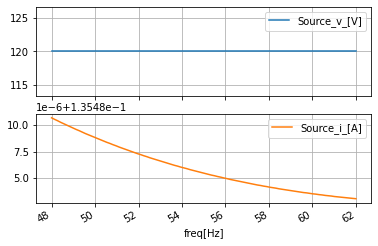

In [24]:
#look at the raw data
ac_data_base_df.plot(subplots=True, sharex=True, grid=True);

,Source_v_[V],Source_i_[A]
freq[Hz],,
48.000000,119.999863,0.445990
48.141415,119.999863,0.436113
48.282829,119.999863,0.426291
48.424244,119.999863,0.416528
48.565655,119.999863,0.406822
...,...,...
61.434345,119.999863,0.462049
61.575756,119.999863,0.469817
61.717171,119.999863,0.477582


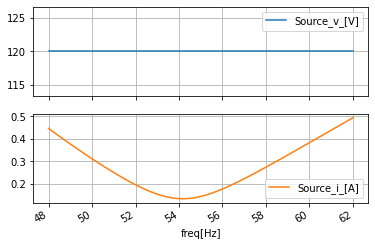

In [25]:
#look at the magnitude
ac_data_mag_df=ac_data_base_df.apply(np.abs, axis=0)
ac_data_mag_df.plot(subplots=True, sharex=True, grid=True);
ac_data_mag_df

,Source_v_[V],Source_i_[A]
freq[Hz],,
48.000000,0.000004,-1.262120
48.141415,0.000003,-1.254890
48.282829,0.000003,-1.247351
48.424244,0.000003,-1.239483
48.565655,0.000003,-1.231265
...,...,...
61.434345,-0.000004,1.273200
61.575756,-0.000004,1.278268
61.717171,-0.000004,1.283161


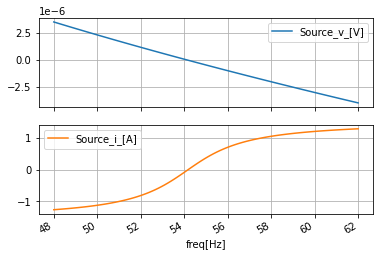

In [26]:
#look at the phase in radians
ac_data_degrad_df=ac_data_base_df.apply(np.angle, axis=0)
ac_data_degrad_df.plot(subplots=True, sharex=True, grid=True);
ac_data_degrad_df

,Source_v_[V],Source_i_[A]
freq[Hz],,
48.000000,0.000203,-72.314148
48.141415,0.000198,-71.899910
48.282829,0.000193,-71.467941
48.424244,0.000188,-71.017143
48.565655,0.000183,-70.546303
...,...,...
61.434345,-0.000211,72.949005
61.575756,-0.000215,73.239349
61.717171,-0.000219,73.519691


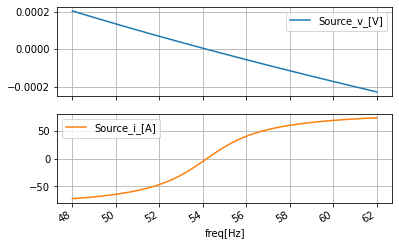

In [27]:
#look at the phase in degrees
ac_data_degang_df=ac_data_base_df.apply(np.angle, axis=0, deg=True)
ac_data_degang_df.plot(subplots=True, sharex=True, grid=True);
ac_data_degang_df

,Source_v_[V],Source_i_[A]
freq[Hz],,
48.000000,0.000203,-72.314150
48.141415,0.000198,-71.899906
48.282829,0.000193,-71.467944
48.424244,0.000188,-71.017145
48.565655,0.000183,-70.546299
...,...,...
61.434345,-0.000211,72.949002
61.575756,-0.000215,73.239347
61.717171,-0.000219,73.519692


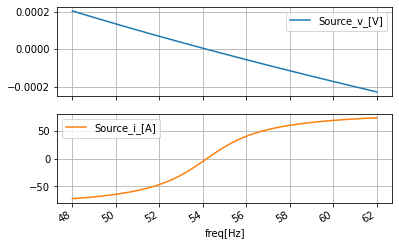

In [28]:
##look at the unwraped-phase
ac_data_deganguw_df=ac_data_base_df.apply(angle_phase_unwrap, axis=0)
ac_data_deganguw_df.plot(subplots=True, sharex=True, grid=True);
ac_data_deganguw_df

In [29]:
#perform all the power calcs
ac_data_power_df=ac_data_base_df.copy()
power_calcs_ac.autogen_powercalcs(ac_data_power_df, 'Source')
ac_data_power_df.columns
ac_data_power_df.head()

,Source_v_[V],Source_i_[A],Source_p_[W],Source_P_[W],Source_Q_[VAR],Source_S_[VA],Source_s_[VA],Source_pf_[],Source_pfang_[deg]
freq[Hz],,,,,,,,,
48.000000,119.999863+0.000425j,0.135491-0.424911j,16.259047-50.989166j,8.129342,25.494640,8.129342+25.494640j,26.759352,0.303794,72.314354
48.141415,119.999863+0.000415j,0.135491-0.414532j,16.259020-49.743675j,8.129338,24.871895,8.129338+24.871895j,26.166721,0.310675,71.900101
48.282829,119.999863+0.000404j,0.135490-0.404186j,16.258995-48.502270j,8.129333,24.251188,8.129333+24.251188j,25.577456,0.317832,71.468132
48.424244,119.999863+0.000394j,0.135490-0.393875j,16.258968-47.264908j,8.129330,23.632507,8.129330+23.632507j,24.991627,0.325282,71.017326
48.565655,119.999863+0.000384j,0.135490-0.383597j,16.258944-46.031555j,8.129325,23.015831,8.129325+23.015831j,24.409309,0.333042,70.546478


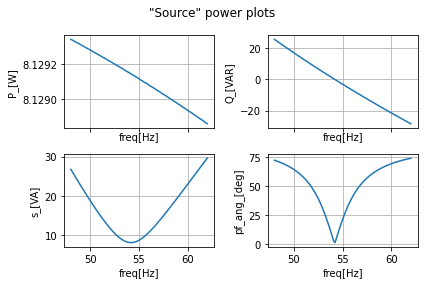

In [30]:
#plot of the powers with a compenstating capcitor
power_calcs_ac.make_power_plot(ac_data_power_df, 'Source')

We see that while we have overall lowered the Reactive power from as high as 120VAR to around $\pm20$[VAR]. We have only succeeded in getting the power factor to near zero at the mean frequency of 55Hz where our mean capacitance was 4.29e-05F. Just within a sweep of 24Hz encompassing 50/60Hz we see that single frequency matching is not effective. If this was a digital single with today's data rates and the frequency range that ideal squarewave encompass this would have been even less effective. Just with power alone this single example where naively using the mean shows that except in the tightest frequency banded systems single-frequency matching doesn't work and instead broadband matching is needed. But we will get to those circuits much much later in this book.

# Two-Phase System¶

The North American two-phase power system in the residential panel is one of the strangest things in electrical engineering that has ever been conceived. If you're not familiar with it I recommend watching the YT video ["The US electrical system is not 120V"](https://youtu.be/jMmUoZh3Hq4) from Technology Connections. Also if you're not familiar with Ground Fault Interpreter (gfi) I recommend watching his YT video on that [The GFCI/RCD: A Simple but Life-Saving Protector](https://youtu.be/ILBjnZq0n8s)


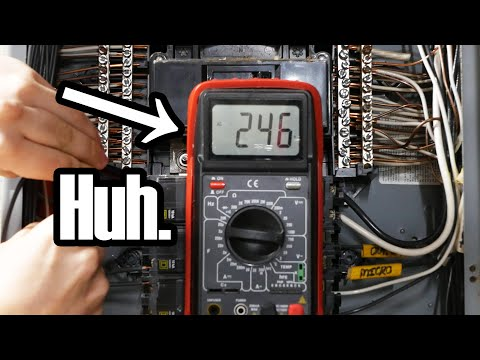

In [31]:
YouTubeVideo('jMmUoZh3Hq4', width=500, height=400)

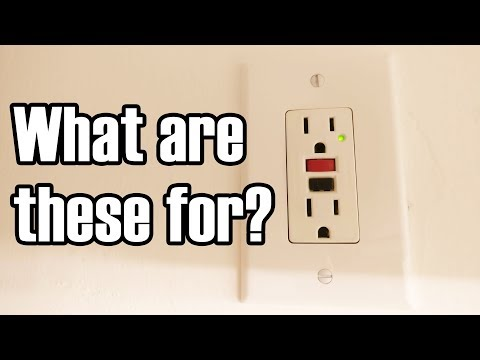

In [32]:
YouTubeVideo('ILBjnZq0n8s', width=500, height=400)

For a shorter video about neutral and ground, I recommend the YT video [The difference between neutral and ground on the electric panel](https://youtu.be/-n8CiU_6KqE) from grayfurnaceman.

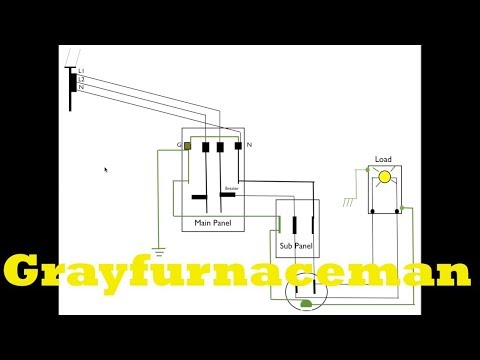

In [33]:
YouTubeVideo('-n8CiU_6KqE', width=500, height=400)

Suffice to say that the neutral branch is the nominal current return path. Where inside the residence at the primary panel earth ground is tied to neutral. Where then all subsequent grounds normally are isolated chaise ground branches. These isolated branches also lead to earth ground but are typically a current return in place of the neutral in a fault situation typical when there is conduction to the chassis. Where this typically happens in an electrical shock instance hence the GFI.

Below we create a rudimentary model of such a North American 2 phase panel. Where we start only at the panel, not the transformer. And in the model, we have the neutral resistively separated from the ground. Whereat the source side this resistance `Rearth` is default set to zero. It can be changed to loosely model the earth ground bonding issue that can occur where then the neutral floats. On the other side of the neutral branch, there is a separation resistor `Rgfi` that is set by default to be open to represent an open chassis ground return path. But can be changed to loosely mimic a ground fault condition. We will play with this in the chapter on transient circuits when we replace that resistor with a switch. So for now we will leave it open. Finally, the neutral and each of the phases have a wire model resistor (`RaA`, `RbB`, `RnN`) These are by default set to O Oms; however, they can be changed to facilitate three things. The source built-in resistance, the interconnection resistance, and or an open fault in the connects. Again, we will not explore those situations here but they are baked into this testbench.

In [34]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section1 two_phase_panel class
#class to create a SPICE model of a North American two-phase power panel
#with ground branch and gfi branch in addition to neutral branch

class two_phase_panel:
    """
    Class to contain the needed Skidl package (method) to invoke the circuit for simulations
    and drawing just the packaged circuit via lcapy.
    
    The circuit in hand is a model of a typical North American 2Phase home panel with resistor separated
    neutral from the ground along with open separation to a parallel gfi path for chassis ground to the earth ground
    """
    
    @subcircuit
    def SKiDl_circ(self, Load_A_posterm, Load_A_neuterm,
                   Load_B_posterm, Load_B_neuterm,
                  RaA=0@u_Ohm, RbB=0@u_Ohm, RnN=0@u_Ohm, 
                  Rearth=0@u_Ohm, Rgfi=1e16@u_Ohm):
        """
        SKiDl subcircuit of a primitive representation of a US 120 2 phase circuit
        panel with resistor separated ground from neutral and open from ground return
        
        Terminals:
            Load_A_posterm: Positive terminal for the A phase load 
            Load_A_neuterm: Neutral terminal for the A phase load 
            Load_B_posterm: Positive terminal for the B phase load 
            Load_B_neuterm: Neutral terminal for the B phase load 
        
        Args:
            RaA (float; 0@u_Ohm; ohms): Resistance between the A source and A terminal
            RbB (float; 0@u_Ohm; ohms): Resistance between the B source and B terminal
            RnN (float; 0@u_Ohm; ohms): Resistance between the N source and N terminal
            Rearth (float; 0@u_Ohm; ohms): Resistance between the earth and neutral
            Rgfi (float; 1e16@u_Ohm; ohms): Resistance between neutral and chassis ground gfi branch
        
        Returns:
            returns a SKiDl subcircuit. Some of the internal elements SkiDl objects
            are also stored in `self.panel_internals` which is a dictionary with 
            names for the objects as keys and the SkiDl object's elements as corresponding values
        """
        
        #ngspice treats net a == net A; so add underbar to save from singular matrix
        net_a=Net('a'); net_A=Net('A_')
        net_b=Net('b'); net_B=Net('B_')
        net_n=Net('n'); net_N=Net('N_')

        #create wire models to deal with voltage source parallel 
        #to inductor singularities 
        phase_a_wire=R(ref='aA', value=RaA); phase_a_wire[1, 2]+=net_a, net_A
        phase_b_wire=R(ref='bB', value=RbB); phase_b_wire[1, 2]+=net_b, net_B
        phase_n_wire=R(ref='nN', value=RnN); phase_n_wire[1, 2]+=net_n, net_N


        #bus neutral to earth
        #create wire (resistor) to isolate neutral and earth ground 
        #can be used to model floating neutral
        earth_n_sep=R(ref='gndbus', value=Rearth)
        #floating neutral monitor
        earth_ammeter=V(ref='amm_earth', dc_value=0@u_V)
        earth_n_sep[1, 2]+=net_n, earth_ammeter['p']
        earth_ammeter['n']+=gnd
        
        #gfi branch
        #isolation from netureal and chaiesse groud at load
        gfi_monter=V(ref='amm_gfi', dc_value=0@u_V)
        #gfi branch currernt monter
        chiasse_n_sep=R(ref='neu_chassie', value=Rgfi);
        net_N & gfi_monter & chiasse_n_sep & gnd
        


        #power behind the pannel
        vs_Aphase=SINEV(ref='A', ac_phase=0,  ac_magnitude=120@u_V)
        vs_Aphase['P', 'N']+=net_a, net_n
        vs_Bphase=SINEV(ref='B', ac_phase=np.deg2rad(-90),  ac_magnitude=120@u_V)
        vs_Bphase['N', 'P']+=net_b, net_n
        
        #supciruct connections
        net_A+=Load_A_posterm
        net_B+=Load_B_posterm
        net_N+=Load_A_neuterm, Load_B_neuterm
        
        #stowe away the elements to read from
        self.panel_internals={'AM_gfi':gfi_monter, 'AM_earth':earth_ammeter, 
                'APhase_Source':vs_Aphase,'BPhase_Source': vs_Bphase}
        
        
        
    
    def draw_me(self):
        """
        method to draw a representation of this subcircuit with 
        load representation with lcapy
        """
        schematic=kiwi.Circuit()
        
        #supplies
        schematic.add('VA a n; down, l=$0^{\circ}$')
        schematic.add('VB n b; down, l=$-90^{\circ}$')
        
        #earth ground leg
        schematic.add('W n n_1; left')
        schematic.add('Rgn n_1, n_2; down, f_>=Idump')
        schematic.add('AMearth n_2 0_1; down')
        schematic.add('W 0_1 0; down=0.2, ground')
        
        #wire legs
        schematic.add('RaA a A_; right=2.5, f_>=Isource')
        schematic.add('RbB b B_; right=2.5, f_>=Isource')
        schematic.add('RnN n N_; right=2.5, f<_=Ireturn')
        
        #loads
        schematic.add('RloadA A_ N_; down')
        schematic.add('RloadB N_ B_; down')
        
        #chaisse gfi branch
        schematic.add('W N_ N1; right')
        schematic.add('Ropen N1 N2; down')
        schematic.add('AMgfi N2 0_2; down, f_>=Igfi')
        schematic.add('W 0_2 0_3; down=0.2, cground')
        
        

        
        schematic.draw()



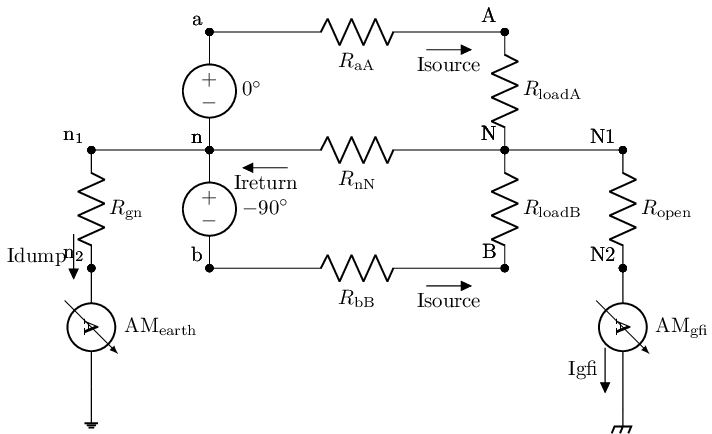

In [35]:
USPanel=two_phase_panel()
USPanel.draw_me()

In [36]:
reset()

#whats on the 220 outlet
arm1=single_arm_mod.SKiDl_pack() 
arm2=single_arm_mod.SKiDl_pack()

USPanel.SKiDl_circ(arm1['P'], arm1['N'], arm2['P'], arm2['N'])


circ=generate_netlist()
print(circ)

.title 
VA a n DC 0V AC 120V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
VB n b DC 0V AC 120V -90.0rad SIN(0V 1V 50Hz 0s 0Hz)
L1 A_ N_7 0.10063694267515924H
L2 N_8 N_9 0.013821656050955413H
L3 N_7 N_ 0.10063694267515924H
L4 N_10 N_11 0.013821656050955413H
L5 B_ N_12 0.10063694267515924H
L6 N_13 N_14 0.013821656050955413H
L7 N_12 N_ 0.10063694267515924H
L8 N_15 N_16 0.013821656050955413H
R10 B_ N_13 0.8Ohm
R11 N_14 N_12 442.0Ohm
R12 N_12 N_15 0.8Ohm
R13 N_16 N_ 442.0Ohm
R6 A_ N_8 0.8Ohm
R7 N_9 N_7 442.0Ohm
R8 N_7 N_10 0.8Ohm
R9 N_11 N_ 442.0Ohm
RaA a A_ 0Ohm
Vamm_earth N_5 0 0V
Vamm_gfi N_ N_6 0V
RbB b B_ 0Ohm
Rgndbus n N_5 0Ohm
RnN n N_ 0Ohm
Rneu_chassie N_6 0 1e+16Ohm




No errors or warnings found during netlist generation.



In [37]:
sim=circ.simulator()
ac_vals=sim.ac(start_frequency=48@u_Hz, stop_frequency=62@u_Hz, number_of_points=100, variation='lin')

In [38]:


ac_data_base_df=pd.DataFrame(index=ac_vals.frequency.as_ndarray())
ac_data_base_df.index.name='freq[Hz]'

ac_data_base_df['SourceA_v_[V]']=ac_vals[node(USPanel.panel_internals['APhase_Source']['P'])].as_ndarray()
ac_data_base_df['SourceA_i_[A]']=-ac_vals[get_skidl_spice_ref(USPanel.panel_internals['APhase_Source'])].as_ndarray()

ac_data_base_df['SourceB_v_[V]']=ac_vals[node(USPanel.panel_internals['BPhase_Source']['N'])].as_ndarray()
ac_data_base_df['SourceB_i_[A]']=-ac_vals[get_skidl_spice_ref(USPanel.panel_internals['BPhase_Source'])].as_ndarray()

ac_data_base_df

,SourceA_v_[V],SourceA_i_[A],SourceB_v_[V],SourceB_i_[A]
freq[Hz],,,,
48.000000,120.000000+0.000000j,0.135550-1.978080j,0.000000+120.000000j,-1.978144-0.135559j
48.141415,120.000000-0.000000j,0.135549-1.972277j,0.000000+120.000000j,-1.972341-0.135558j
48.282829,120.000000+0.000000j,0.135549-1.966508j,0.000000+120.000000j,-1.966572-0.135558j
48.424244,120.000000+0.000000j,0.135548-1.960772j,0.000000+120.000000j,-1.960836-0.135557j
48.565655,120.000000+0.000000j,0.135548-1.955071j,-0.000000+120.000000j,-1.955134-0.135557j
...,...,...,...,...
61.434345,120.000000+0.000000j,0.135518-1.546158j,0.000000+120.000000j,-1.546198-0.135525j
61.575756,120.000000+0.000000j,0.135517-1.542615j,-0.000000+120.000000j,-1.542654-0.135524j
61.717171,120.000000-0.000000j,0.135517-1.539088j,0.000000+120.000000j,-1.539127-0.135524j


From here we will look that the power on each phase and across the phases

array([<AxesSubplot:xlabel='freq[Hz]'>, <AxesSubplot:xlabel='freq[Hz]'>],
      dtype=object)

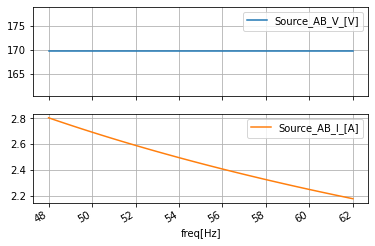

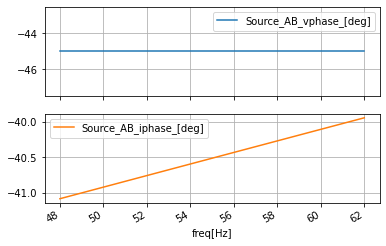

In [39]:
ac_data_AB=ac_data_base_df.copy()
ac_data_AB['Source_AB_v_[V]']=ac_data_AB['SourceA_v_[V]']-ac_data_AB['SourceB_v_[V]']
ac_data_AB['Source_AB_V_[V]']=np.abs(ac_data_AB['Source_AB_v_[V]'])
ac_data_AB['Source_AB_vphase_[deg]']=np.angle(ac_data_AB['Source_AB_v_[V]'], True)

ac_data_AB['Source_AB_i_[A]']=ac_data_AB['SourceA_i_[A]']-ac_data_AB['SourceB_i_[A]']
ac_data_AB['Source_AB_I_[A]']=np.abs(ac_data_AB['Source_AB_i_[A]'])
ac_data_AB['Source_AB_iphase_[deg]']=np.angle(ac_data_AB['Source_AB_i_[A]'], True)


ac_data_AB.plot(y=['Source_AB_V_[V]', 'Source_AB_I_[A]'], subplots=True, sharex=True, grid=True)
ac_data_AB.plot(y=['Source_AB_vphase_[deg]', 'Source_AB_iphase_[deg]'], subplots=True, sharex=True, grid=True)


,SourceA_v_[V],SourceA_i_[A],SourceB_v_[V],SourceB_i_[A],Source_AB_v_[V],Source_AB_V_[V],Source_AB_vphase_[deg],Source_AB_i_[A],Source_AB_I_[A],Source_AB_iphase_[deg],Source_AB_p_[W],Source_AB_P_[W],Source_AB_Q_[VAR],Source_AB_S_[VA],Source_AB_s_[VA],Source_AB_pf_[],Source_AB_pfang_[deg]
freq[Hz],,,,,,,,,,,,,,,,,
48.000000,120.000000+0.000000j,0.135550-1.978080j,0.000000+120.000000j,-1.978144-0.135559j,120.000000-120.000000j,169.705627,-45.0,2.113694-1.842521j,2.804030,-41.078873,32.540817-474.745789j,237.372894,-16.270409,237.372894-16.270409j,237.929855,0.997659,3.921114
48.141415,120.000000-0.000000j,0.135549-1.972277j,0.000000+120.000000j,-1.972341-0.135558j,120.000000-120.000000j,169.705627,-45.0,2.107890-1.836718j,2.795843,-41.067390,32.540634-473.353027j,236.676514,-16.270317,236.676514-16.270317j,237.235107,0.997645,3.932633
48.282829,120.000000+0.000000j,0.135549-1.966508j,0.000000+120.000000j,-1.966572-0.135558j,120.000000-120.000000j,169.705627,-45.0,2.102121-1.830950j,2.787703,-41.055908,32.540482-471.968445j,235.984222,-16.270241,235.984222-16.270241j,236.544449,0.997632,3.944119
48.424244,120.000000+0.000000j,0.135548-1.960772j,0.000000+120.000000j,-1.960836-0.135557j,120.000000-120.000000j,169.705627,-45.0,2.096385-1.825215j,2.779611,-41.044426,32.540329-470.591980j,235.295990,-16.270164,235.295990-16.270164j,235.857834,0.997618,3.955522
48.565655,120.000000+0.000000j,0.135548-1.955071j,-0.000000+120.000000j,-1.955134-0.135557j,120.000000-120.000000j,169.705627,-45.0,2.090682-1.819514j,2.771567,-41.032948,32.540176-469.223511j,234.611755,-16.270088,234.611755-16.270088j,235.175232,0.997604,3.967041


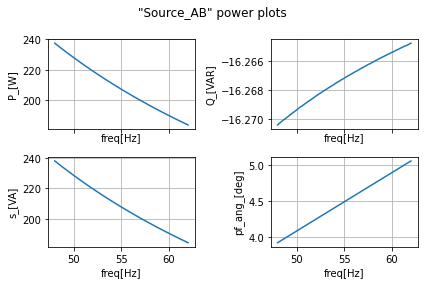

In [40]:
power_calcs_ac.autogen_powercalcs(ac_data_AB, 'Source_AB')
power_calcs_ac.make_power_plot(ac_data_AB, 'Source_AB')
ac_data_AB.head()


,SourceA_v_[V],SourceA_i_[A],SourceB_v_[V],SourceB_i_[A],SourceA_p_[W],SourceA_P_[W],SourceA_Q_[VAR],SourceA_S_[VA],SourceA_s_[VA],SourceA_pf_[],SourceA_pfang_[deg]
freq[Hz],,,,,,,,,,,
48.000000,120.000000+0.000000j,0.135550-1.978080j,0.000000+120.000000j,-1.978144-0.135559j,16.265974-237.369553j,8.132987,118.684776,8.132987+118.684776j,118.963112,0.068366,86.079880
48.141415,120.000000-0.000000j,0.135549-1.972277j,0.000000+120.000000j,-1.972341-0.135558j,16.265923-236.673187j,8.132961,118.336594,8.132961+118.336594j,118.615746,0.068566,86.068390
48.282829,120.000000+0.000000j,0.135549-1.966508j,0.000000+120.000000j,-1.966572-0.135558j,16.265869-235.980927j,8.132935,117.990463,8.132935+117.990463j,118.270424,0.068766,86.056908
48.424244,120.000000+0.000000j,0.135548-1.960772j,0.000000+120.000000j,-1.960836-0.135557j,16.265816-235.292694j,8.132908,117.646347,8.132908+117.646347j,117.927124,0.068966,86.045418
48.565655,120.000000+0.000000j,0.135548-1.955071j,-0.000000+120.000000j,-1.955134-0.135557j,16.265764-234.608475j,8.132882,117.304237,8.132882+117.304237j,117.585831,0.069165,86.033936


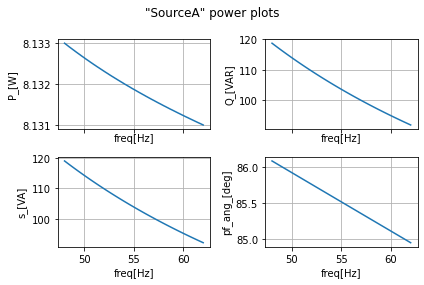

In [41]:
power_calcs_ac.autogen_powercalcs(ac_data_base_df, 'SourceA')
power_calcs_ac.make_power_plot(ac_data_base_df, 'SourceA')
ac_data_base_df.head()

,SourceA_v_[V],SourceA_i_[A],SourceB_v_[V],SourceB_i_[A],SourceA_p_[W],SourceA_P_[W],SourceA_Q_[VAR],SourceA_S_[VA],SourceA_s_[VA],SourceA_pf_[],SourceA_pfang_[deg],SourceB_p_[W],SourceB_P_[W],SourceB_Q_[VAR],SourceB_S_[VA],SourceB_s_[VA],SourceB_pf_[],SourceB_pfang_[deg]
freq[Hz],,,,,,,,,,,,,,,,,,
48.000000,120.000000+0.000000j,0.135550-1.978080j,0.000000+120.000000j,-1.978144-0.135559j,16.265974-237.369553j,8.132987,118.684776,8.132987+118.684776j,118.963112,0.068366,86.079880,16.267048-237.377335j,-8.133524,-118.688667,-8.133524-118.688667j,118.967026,-0.068368,93.920242
48.141415,120.000000-0.000000j,0.135549-1.972277j,0.000000+120.000000j,-1.972341-0.135558j,16.265923-236.673187j,8.132961,118.336594,8.132961+118.336594j,118.615746,0.068566,86.068390,16.266991-236.680923j,-8.133495,-118.340462,-8.133495-118.340462j,118.619637,-0.068568,93.931725
48.282829,120.000000+0.000000j,0.135549-1.966508j,0.000000+120.000000j,-1.966572-0.135558j,16.265869-235.980927j,8.132935,117.990463,8.132935+117.990463j,118.270424,0.068766,86.056908,16.266935-235.988617j,-8.133468,-117.994308,-8.133468-117.994308j,118.274300,-0.068768,93.943214
48.424244,120.000000+0.000000j,0.135548-1.960772j,0.000000+120.000000j,-1.960836-0.135557j,16.265816-235.292694j,8.132908,117.646347,8.132908+117.646347j,117.927124,0.068966,86.045418,16.266880-235.300339j,-8.133440,-117.650169,-8.133440-117.650169j,117.930977,-0.068968,93.954697
48.565655,120.000000+0.000000j,0.135548-1.955071j,-0.000000+120.000000j,-1.955134-0.135557j,16.265764-234.608475j,8.132882,117.304237,8.132882+117.304237j,117.585831,0.069165,86.033936,16.266825-234.616089j,-8.133412,-117.308044,-8.133412-117.308044j,117.589668,-0.069168,93.966179


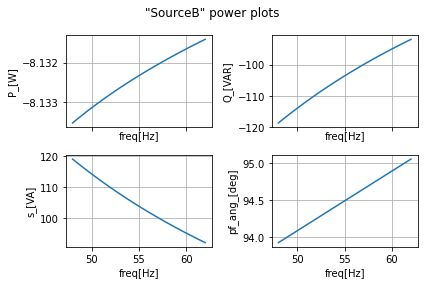

In [42]:
power_calcs_ac.autogen_powercalcs(ac_data_base_df, 'SourceB')
power_calcs_ac.make_power_plot(ac_data_base_df, 'SourceB')
ac_data_base_df.head()

# Three Phase Four Wire Y (Star) Topology ¶
To be complete we also model the two variations of three-phase circuit topologies commonly found. We will start with the so-called Y (or star) topology which from a circuit topology standpoint is just a variation of the North American two-phase. Where a third C phase is added and all the phase source negative terminal are bounded to the neutral with 120 degrees of separation between the phases. Thus the Y topology testbench below includes the same overall structures as the `two_phase_panel` testbench has with resistor isolated neutral with separate branches to earth and chassis return.


In [43]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section1 three_phaseY_panel class
#class to create a SPICE model of a three-phase Y source
#with ground branch and gfi branch in addition to neutral branch

class three_phaseY_panel:
    """
    Class to contain the needed Skidl package (method) to invoke the circuit for simulations
    and drawing just the packaged circuit via lcapy.
    
    The circuit in hand is a model of a 3 phase Y (star) source circuit with resistor separated
    neutral from the ground along with an open separation to a parallel gfi path for chassis ground to the earth ground
    """
    def __init__(self):
        pass
    
    @subcircuit
    def SKiDl_circ(self, Load_A_posterm, Load_A_neuterm,
                   Load_B_posterm, Load_B_neuterm,
                   Load_C_posterm, Load_C_neuterm,
                  RaA=0@u_Ohm, RbB=0@u_Ohm, RcC=0@u_Ohm, RnN=0@u_Ohm, 
                  Rearth=0@u_Ohm, Rgfi=1e16@u_Ohm):
        """
        SKiDl subcircuit of a primitive representation of a 3 phase Y (star)  circuit
        panel with resistor separated ground from neutral and open from ground return
        
        Terminals:
            Load_A_posterm: Positive terminal for the A phase load 
            Load_A_neuterm: Neutral terminal for the A phase load 
            Load_B_posterm: Positive terminal for the B phase load 
            Load_B_neuterm: Neutral termanl for the B phase load
            Load_C_posterm: Positive terminal for the C phase load 
            Load_C_neuterm: Neutral terminal for the C phase load 
        
        Args:
            RaA (float; 0@u_Ohm; ohms): Resistance between the A source and A terminal
            RbB (float; 0@u_Ohm; ohms): Resistance between the B source and B terminal
            RcC (float; 0@u_Ohm; ohms): Resistance between the C source and C terminal
            RnN (float; 0@u_Ohm; ohms): Resistance between the N source and N terminal
            Rearth (float; 0@u_Ohm; ohms): Resistance between the earth and neutral
            Rgfi (float; 1e16@u_Ohm; ohms): Resistance between neutral and chassis ground gfi branch
        
        Returns:
            returns a SKiDl subcircuit. Some of the internal elements SkiDl objects
            are also stored in `self.panel_internals` which is a dictionary with 
            names for the objects as keys and the SkiDl object's elements as corresponding values
        """
        
        #ngspice treats net a == net A; so add underbar to save from singular matrix
        net_a=Net('a'); net_A=Net('A_')
        net_b=Net('b'); net_B=Net('B_')
        net_c=Net('c'); net_C=Net('C_')
        net_n=Net('n'); net_N=Net('N_')

        #create wire models to deal with voltage source parallel 
        #to inductor singularities 
        phase_a_wire=R(ref='aA', value=RaA); phase_a_wire[1, 2]+=net_a, net_A
        phase_b_wire=R(ref='bB', value=RbB); phase_b_wire[1, 2]+=net_b, net_B
        phase_c_wire=R(ref='cC', value=RcC); phase_c_wire[1, 2]+=net_c, net_C
        phase_n_wire=R(ref='nN', value=RnN); phase_n_wire[1, 2]+=net_n, net_N


        #bus neutral to earth
        #create wire (resistor) to isolate neutral and earth ground 
        #can be used to model floating neutral
        earth_n_sep=R(ref='gndbus', value=Rearth)
        #floating neutral monitor
        earth_ammeter=V(ref='amm_earth', dc_value=0@u_V)
        earth_n_sep[1, 2]+=net_n, earth_ammeter['p']
        earth_ammeter['n']+=gnd
        
        #gfi branch
        #isolation from netureal and chaiesse groud at load
        gfi_monter=V(ref='amm_gfi', dc_value=0@u_V)
        #gfi branch currernt monter
        chiasse_n_sep=R(ref='neu_chassie', value=Rgfi);
        net_N & gfi_monter & chiasse_n_sep & gnd
        


        #power behind the pannel
        vs_Aphase=SINEV(ref='A', ac_phase=0,  ac_magnitude=120@u_V)
        vs_Aphase['P', 'N']+=net_a, net_n
        vs_Bphase=SINEV(ref='B', ac_phase=np.deg2rad(-120),  ac_magnitude=120@u_V)
        vs_Bphase['P', 'N']+=net_b, net_n
        vs_Cphase=SINEV(ref='C', ac_phase=np.deg2rad(120),  ac_magnitude=120@u_V)
        vs_Cphase['P', 'N']+=net_c, net_n
        
        #supciruct connections
        net_A+=Load_A_posterm
        net_B+=Load_B_posterm
        net_C+=Load_C_posterm
        net_N+=Load_A_neuterm, Load_B_neuterm, Load_C_neuterm
        
        #stowe away the elements to read from
        self.panel_internals={'AM_gfi':gfi_monter, 'AM_earth':earth_ammeter, 
                'APhase_Source':vs_Aphase,'BPhase_Source': vs_Bphase, 'CPhase_Source': vs_Cphase}
        
        
        
    
    def draw_me(self):
        """
        method to draw a representation of this subcircuit with 
        load representation with lcapy
        """
        schematic=kiwi.Circuit()
        
        #supplies
        schematic.add('VA a na; down=3, l=$0^{\circ}$')
        schematic.add('W na nb; right')
        schematic.add('VB b nb; down=2, l=$-120^{\circ}$')
        schematic.add('W nb nc; right')
        schematic.add('VC c nc; down, l=$120^{\circ}$')

        
        #earth ground leg
        schematic.add('W na n_1; left')
        schematic.add('Rgn n_1, n_2; down, f_>=Idump')
        schematic.add('AMearth n_2 0_1; down')
        schematic.add('W 0_1 0; down=0.2, ground')
        
        #wire legs
        schematic.add('RaA a A_; right=2.5, f_>=Isource')
        schematic.add('RbB b B_; right=2.5, f_>=Isource')
        schematic.add('RcC c C_; right=2.5, f_>=Isource')
        schematic.add('RnN nc N_C; right=2.5, f<_=Ireturn')
        
        #loads
        schematic.add('RloadC C_ N_C; down')
        schematic.add('W N_C N_B; right')
        schematic.add('RloadB B_ N_B; down')
        schematic.add('W N_B N_A; right')
        schematic.add('RloadA A_ N_A; down')

        
        #chaisse gfi branch
        schematic.add('W N_A N1; right')
        schematic.add('Ropen N1 N2; down')
        schematic.add('AMgfi N2 0_2; down, f_>=Igfi')
        schematic.add('W 0_2 0_3; down=0.2, cground')
        
        

        
        schematic.draw()


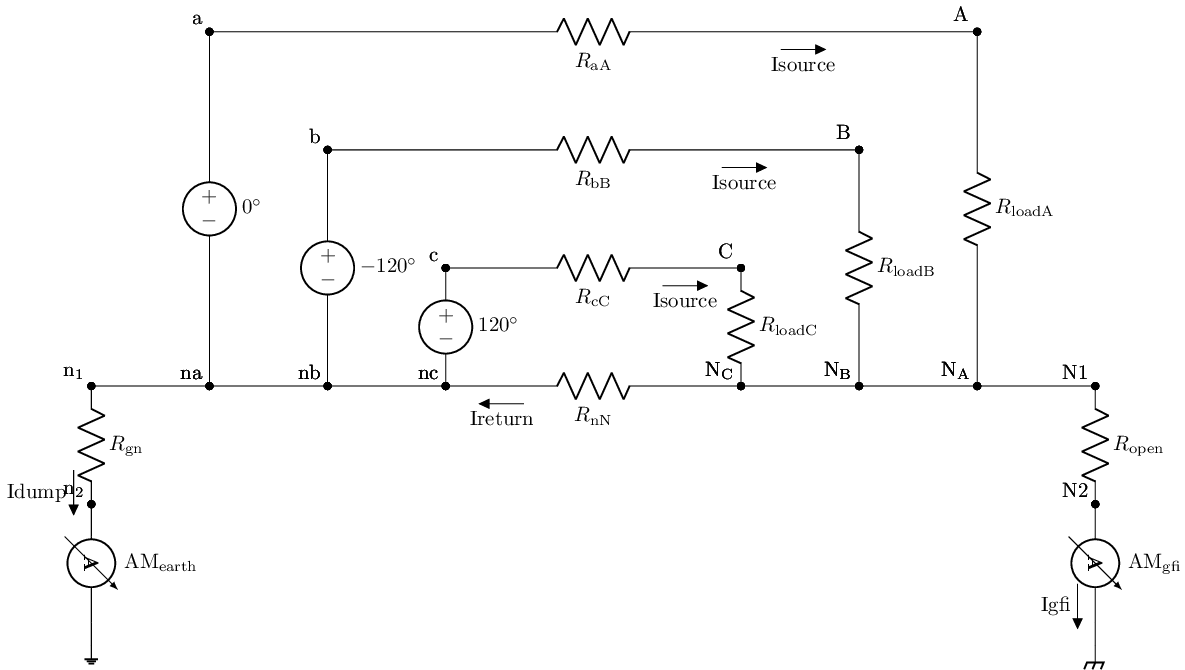

In [44]:
Y3=three_phaseY_panel()
Y3.draw_me()

In [45]:
reset()
arm1=single_arm_mod.SKiDl_pack() 
arm2=single_arm_mod.SKiDl_pack()
arm3=single_arm_mod.SKiDl_pack()


Y3.SKiDl_circ(arm1['P'], arm1['N'], arm2['P'], arm2['N'], arm3['P'], arm3['N'])


circ=generate_netlist()
print(circ)

.title 
VA a n DC 0V AC 120V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
VB b n DC 0V AC 120V -119.99999999999999rad SIN(0V 1V 50Hz 0s 0Hz)
VC c n DC 0V AC 120V 119.99999999999999rad SIN(0V 1V 50Hz 0s 0Hz)
L1 A_ N_9 0.10063694267515924H
L10 N_20 N_21 0.013821656050955413H
L11 N_19 N_ 0.10063694267515924H
L12 N_22 N_23 0.013821656050955413H
L2 N_10 N_11 0.013821656050955413H
L3 N_9 N_ 0.10063694267515924H
L4 N_12 N_13 0.013821656050955413H
L5 B_ N_14 0.10063694267515924H
L6 N_15 N_16 0.013821656050955413H
L7 N_14 N_ 0.10063694267515924H
L8 N_17 N_18 0.013821656050955413H
L9 C_ N_19 0.10063694267515924H
R10 N_13 N_ 442.0Ohm
R11 B_ N_15 0.8Ohm
R12 N_16 N_14 442.0Ohm
R13 N_14 N_17 0.8Ohm
R14 N_18 N_ 442.0Ohm
R15 C_ N_20 0.8Ohm
R16 N_21 N_19 442.0Ohm
R17 N_19 N_22 0.8Ohm
R18 N_23 N_ 442.0Ohm
R7 A_ N_10 0.8Ohm
R8 N_11 N_9 442.0Ohm
R9 N_9 N_12 0.8Ohm
RaA a A_ 0Ohm
Vamm_earth N_7 0 0V
Vamm_gfi N_ N_8 0V
RbB b B_ 0Ohm
RcC c C_ 0Ohm
Rgndbus n N_7 0Ohm
RnN n N_ 0Ohm
Rneu_chassie N_8 0 1e+16Ohm




No errors or warnings found during netlist generation.



In [46]:
sim=circ.simulator()
ac_vals=sim.ac(start_frequency=48@u_Hz, stop_frequency=62@u_Hz, number_of_points=100, variation='lin')

In [47]:
ac_data_base_df=pd.DataFrame(index=ac_vals.frequency.as_ndarray())
ac_data_base_df.index.name='freq[Hz]'

ac_data_base_df['SourceA_v_[V]']=ac_vals[node(Y3.panel_internals['APhase_Source']['P'])].as_ndarray()
ac_data_base_df['SourceA_i_[A]']=-ac_vals[get_skidl_spice_ref(Y3.panel_internals['APhase_Source'])].as_ndarray()

ac_data_base_df['SourceB_v_[V]']=ac_vals[node(Y3.panel_internals['BPhase_Source']['P'])].as_ndarray()
ac_data_base_df['SourceB_i_[A]']=-ac_vals[get_skidl_spice_ref(Y3.panel_internals['BPhase_Source'])].as_ndarray()

ac_data_base_df['SourceC_v_[V]']=ac_vals[node(Y3.panel_internals['CPhase_Source']['P'])].as_ndarray()
ac_data_base_df['SourceC_i_[A]']=-ac_vals[get_skidl_spice_ref(Y3.panel_internals['CPhase_Source'])].as_ndarray()


ac_data_base_df

,SourceA_v_[V],SourceA_i_[A],SourceB_v_[V],SourceB_i_[A],SourceC_v_[V],SourceC_i_[A]
freq[Hz],,,,,,
48.000000,120.000000+0.000000j,0.135522-1.978116j,-60.000000-103.923050j,-1.780860+0.871693j,-60.000000+103.923050j,1.645338+1.106423j
48.141415,120.000000-0.000000j,0.135522-1.972313j,-60.000000-103.923050j,-1.775834+0.868792j,-60.000000+103.923050j,1.640313+1.103522j
48.282829,120.000000+0.000000j,0.135521-1.966544j,-60.000000-103.923050j,-1.770838+0.865907j,-60.000000+103.923050j,1.635316+1.100637j
48.424244,120.000000+0.000000j,0.135521-1.960809j,-60.000000-103.923050j,-1.765871+0.863040j,-60.000000+103.923050j,1.630350+1.097769j
48.565655,120.000000-0.000000j,0.135521-1.955107j,-60.000000-103.923050j,-1.760932+0.860189j,-60.000000+103.923050j,1.625412+1.094918j
...,...,...,...,...,...,...
61.434345,120.000000+0.000000j,0.135501-1.546182j,-60.000000-103.923050j,-1.406783+0.655743j,-60.000000+103.923050j,1.271282+0.890438j
61.575756,120.000000+0.000000j,0.135501-1.542638j,-60.000000-103.923050j,-1.403714+0.653972j,-60.000000+103.923050j,1.268213+0.888667j
61.717171,120.000000+0.000000j,0.135501-1.539111j,-60.000000-103.923050j,-1.400660+0.652208j,-60.000000+103.923050j,1.265159+0.886903j


array([<AxesSubplot:xlabel='freq[Hz]'>, <AxesSubplot:xlabel='freq[Hz]'>],
      dtype=object)

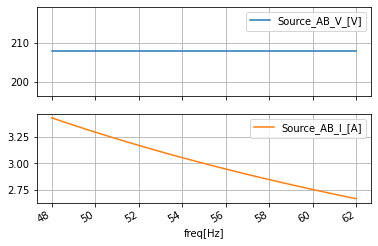

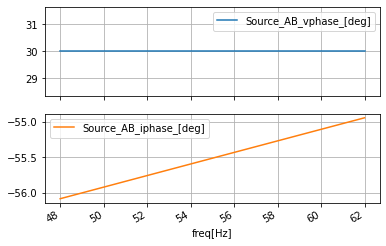

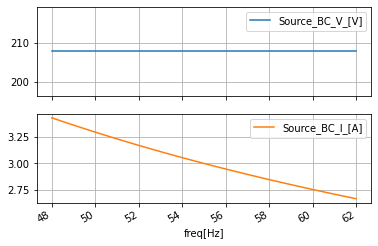

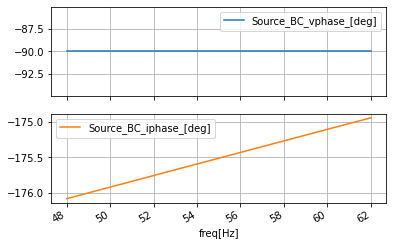

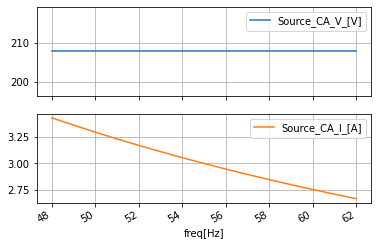

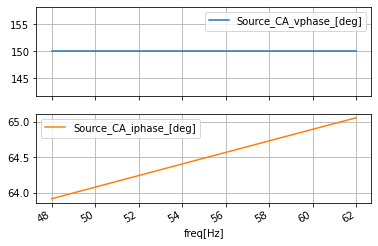

In [48]:
ac_data_ABC=ac_data_base_df.copy()

#AB voltage
ac_data_ABC['Source_AB_v_[V]']=ac_data_ABC['SourceA_v_[V]']-ac_data_ABC['SourceB_v_[V]']
ac_data_ABC['Source_AB_V_[V]']=np.abs(ac_data_ABC['Source_AB_v_[V]'])
ac_data_ABC['Source_AB_vphase_[deg]']=np.angle(ac_data_ABC['Source_AB_v_[V]'], True)

#AB current
ac_data_ABC['Source_AB_i_[A]']=ac_data_ABC['SourceA_i_[A]']-ac_data_ABC['SourceB_i_[A]']
ac_data_ABC['Source_AB_I_[A]']=np.abs(ac_data_ABC['Source_AB_i_[A]'])
ac_data_ABC['Source_AB_iphase_[deg]']=np.angle(ac_data_ABC['Source_AB_i_[A]'], True)

####################################################################################
#BC voltage
ac_data_ABC['Source_BC_v_[V]']=ac_data_ABC['SourceB_v_[V]']-ac_data_ABC['SourceC_v_[V]']
ac_data_ABC['Source_BC_V_[V]']=np.abs(ac_data_ABC['Source_BC_v_[V]'])
ac_data_ABC['Source_BC_vphase_[deg]']=np.angle(ac_data_ABC['Source_BC_v_[V]'], True)

#BC current
ac_data_ABC['Source_BC_i_[A]']=ac_data_ABC['SourceB_i_[A]']-ac_data_ABC['SourceC_i_[A]']
ac_data_ABC['Source_BC_I_[A]']=np.abs(ac_data_ABC['Source_BC_i_[A]'])
ac_data_ABC['Source_BC_iphase_[deg]']=np.angle(ac_data_ABC['Source_BC_i_[A]'], True)

####################################################################################
#CA voltage
ac_data_ABC['Source_CA_v_[V]']=ac_data_ABC['SourceC_v_[V]']-ac_data_ABC['SourceA_v_[V]']
ac_data_ABC['Source_CA_V_[V]']=np.abs(ac_data_ABC['Source_CA_v_[V]'])
ac_data_ABC['Source_CA_vphase_[deg]']=np.angle(ac_data_ABC['Source_CA_v_[V]'], True)

#CA current
ac_data_ABC['Source_CA_i_[A]']=ac_data_ABC['SourceC_i_[A]']-ac_data_ABC['SourceA_i_[A]']
ac_data_ABC['Source_CA_I_[A]']=np.abs(ac_data_ABC['Source_CA_i_[A]'])
ac_data_ABC['Source_CA_iphase_[deg]']=np.angle(ac_data_ABC['Source_CA_i_[A]'], True)


ac_data_ABC.plot(y=['Source_AB_V_[V]', 'Source_AB_I_[A]'], subplots=True, sharex=True, grid=True)
ac_data_ABC.plot(y=['Source_AB_vphase_[deg]', 'Source_AB_iphase_[deg]'], subplots=True, sharex=True, grid=True)

ac_data_ABC.plot(y=['Source_BC_V_[V]', 'Source_BC_I_[A]'], subplots=True, sharex=True, grid=True)
ac_data_ABC.plot(y=['Source_BC_vphase_[deg]', 'Source_BC_iphase_[deg]'], subplots=True, sharex=True, grid=True)

ac_data_ABC.plot(y=['Source_CA_V_[V]', 'Source_CA_I_[A]'], subplots=True, sharex=True, grid=True)
ac_data_ABC.plot(y=['Source_CA_vphase_[deg]', 'Source_CA_iphase_[deg]'], subplots=True, sharex=True, grid=True)

,SourceA_v_[V],SourceA_i_[A],SourceB_v_[V],SourceB_i_[A],SourceC_v_[V],SourceC_i_[A],Source_AB_v_[V],Source_AB_V_[V],Source_AB_vphase_[deg],Source_AB_i_[A],...,Source_CA_i_[A],Source_CA_I_[A],Source_CA_iphase_[deg],Source_AB_p_[W],Source_AB_P_[W],Source_AB_Q_[VAR],Source_AB_S_[VA],Source_AB_s_[VA],Source_AB_pf_[],Source_AB_pfang_[deg]
freq[Hz],,,,,,,,,,,,,,,,,,,,,
48.000000,120.000000+0.000000j,0.135522-1.978116j,-60.000000-103.923050j,-1.780860+0.871693j,-60.000000+103.923050j,1.645338+1.106423j,180.000000+103.923050j,207.8461,30.000002,1.916382-2.849809j,...,1.509816+3.084540j,3.434229,63.919239,641.109558-313.809387j,24.393921,356.060944,24.393921+356.060944j,356.895599,0.06835,86.080750
48.141415,120.000000-0.000000j,0.135522-1.972313j,-60.000000-103.923050j,-1.775834+0.868792j,-60.000000+103.923050j,1.640313+1.103522j,180.000000+103.923050j,207.8461,30.000002,1.911356-2.841105j,...,1.504791+3.075835j,3.424202,63.930729,639.300293-312.764954j,24.393890,355.016388,24.393890+355.016388j,355.853485,0.06855,86.069267
48.282829,120.000000+0.000000j,0.135521-1.966544j,-60.000000-103.923050j,-1.770838+0.865907j,-60.000000+103.923050j,1.635316+1.100637j,180.000000+103.923050j,207.8461,30.000002,1.906359-2.832451j,...,1.499795+3.067181j,3.414233,63.942215,637.501587-311.726593j,24.393814,353.977966,24.393814+353.977966j,354.817505,0.06875,86.057785
48.424244,120.000000+0.000000j,0.135521-1.960809j,-60.000000-103.923050j,-1.765871+0.863040j,-60.000000+103.923050j,1.630350+1.097769j,180.000000+103.923050j,207.8461,30.000002,1.901392-2.823848j,...,1.494829+3.058578j,3.404322,63.953705,635.713501-310.694275j,24.393784,352.945587,24.393784+352.945587j,353.787567,0.06895,86.046295
48.565655,120.000000-0.000000j,0.135521-1.955107j,-60.000000-103.923050j,-1.760932+0.860189j,-60.000000+103.923050j,1.625412+1.094918j,180.000000+103.923050j,207.8461,30.000002,1.896453-2.815296j,...,1.489891+3.050025j,3.394470,63.965187,633.935669-309.668030j,24.393723,351.919220,24.393723+351.919220j,352.763641,0.06915,86.034805


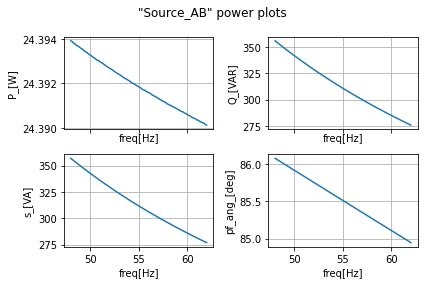

In [49]:
power_calcs_ac.autogen_powercalcs(ac_data_ABC, 'Source_AB')
power_calcs_ac.make_power_plot(ac_data_ABC, 'Source_AB')
ac_data_ABC.head()


,SourceA_v_[V],SourceA_i_[A],SourceB_v_[V],SourceB_i_[A],SourceC_v_[V],SourceC_i_[A],Source_AB_v_[V],Source_AB_V_[V],Source_AB_vphase_[deg],Source_AB_i_[A],...,Source_AB_s_[VA],Source_AB_pf_[],Source_AB_pfang_[deg],Source_BC_p_[W],Source_BC_P_[W],Source_BC_Q_[VAR],Source_BC_S_[VA],Source_BC_s_[VA],Source_BC_pf_[],Source_BC_pfang_[deg]
freq[Hz],,,,,,,,,,,,,,,,,,,,,
48.000000,120.000000+0.000000j,0.135522-1.978116j,-60.000000-103.923050j,-1.780860+0.871693j,-60.000000+103.923050j,1.645338+1.106423j,180.000000+103.923050j,207.8461,30.000002,1.916382-2.849809j,...,356.895599,0.06835,86.080750,-48.787842+712.121887j,24.393921,356.060944,24.393921+356.060944j,356.895599,0.06835,86.080750
48.141415,120.000000-0.000000j,0.135522-1.972313j,-60.000000-103.923050j,-1.775834+0.868792j,-60.000000+103.923050j,1.640313+1.103522j,180.000000+103.923050j,207.8461,30.000002,1.911356-2.841105j,...,355.853485,0.06855,86.069267,-48.787754+710.032776j,24.393877,355.016388,24.393877+355.016388j,355.853485,0.06855,86.069267
48.282829,120.000000+0.000000j,0.135521-1.966544j,-60.000000-103.923050j,-1.770838+0.865907j,-60.000000+103.923050j,1.635316+1.100637j,180.000000+103.923050j,207.8461,30.000002,1.906359-2.832451j,...,354.817505,0.06875,86.057785,-48.787666+707.955872j,24.393833,353.977936,24.393833+353.977936j,354.817474,0.06875,86.057777
48.424244,120.000000+0.000000j,0.135521-1.960809j,-60.000000-103.923050j,-1.765871+0.863040j,-60.000000+103.923050j,1.630350+1.097769j,180.000000+103.923050j,207.8461,30.000002,1.901392-2.823848j,...,353.787567,0.06895,86.046295,-48.787567+705.891113j,24.393784,352.945557,24.393784+352.945557j,353.787537,0.06895,86.046295
48.565655,120.000000-0.000000j,0.135521-1.955107j,-60.000000-103.923050j,-1.760932+0.860189j,-60.000000+103.923050j,1.625412+1.094918j,180.000000+103.923050j,207.8461,30.000002,1.896453-2.815296j,...,352.763641,0.06915,86.034805,-48.787479+703.838440j,24.393740,351.919220,24.393740+351.919220j,352.763641,0.06915,86.034805


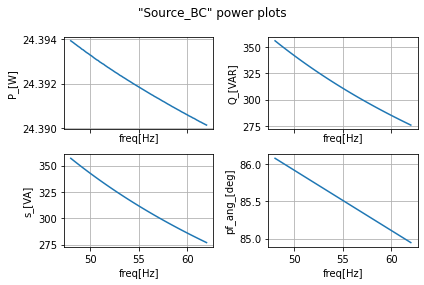

In [50]:
power_calcs_ac.autogen_powercalcs(ac_data_ABC, 'Source_BC')
power_calcs_ac.make_power_plot(ac_data_ABC, 'Source_BC')
ac_data_ABC.head()


,SourceA_v_[V],SourceA_i_[A],SourceB_v_[V],SourceB_i_[A],SourceC_v_[V],SourceC_i_[A],Source_AB_v_[V],Source_AB_V_[V],Source_AB_vphase_[deg],Source_AB_i_[A],...,Source_BC_s_[VA],Source_BC_pf_[],Source_BC_pfang_[deg],Source_CA_p_[W],Source_CA_P_[W],Source_CA_Q_[VAR],Source_CA_S_[VA],Source_CA_s_[VA],Source_CA_pf_[],Source_CA_pfang_[deg]
freq[Hz],,,,,,,,,,,,,,,,,,,,,
48.000000,120.000000+0.000000j,0.135522-1.978116j,-60.000000-103.923050j,-1.780860+0.871693j,-60.000000+103.923050j,1.645338+1.106423j,180.000000+103.923050j,207.8461,30.000002,1.916382-2.849809j,...,356.895599,0.06835,86.080750,-592.321777-398.312439j,24.393906,356.060944,24.393906+356.060944j,356.895599,0.06835,86.080757
48.141415,120.000000-0.000000j,0.135522-1.972313j,-60.000000-103.923050j,-1.775834+0.868792j,-60.000000+103.923050j,1.640313+1.103522j,180.000000+103.923050j,207.8461,30.000002,1.911356-2.841105j,...,355.853485,0.06855,86.069267,-590.512573-397.267761j,24.393875,355.016388,24.393875+355.016388j,355.853485,0.06855,86.069267
48.282829,120.000000+0.000000j,0.135521-1.966544j,-60.000000-103.923050j,-1.770838+0.865907j,-60.000000+103.923050j,1.635316+1.100637j,180.000000+103.923050j,207.8461,30.000002,1.906359-2.832451j,...,354.817474,0.06875,86.057777,-588.713989-396.229309j,24.393845,353.977936,24.393845+353.977936j,354.817474,0.06875,86.057777
48.424244,120.000000+0.000000j,0.135521-1.960809j,-60.000000-103.923050j,-1.765871+0.863040j,-60.000000+103.923050j,1.630350+1.097769j,180.000000+103.923050j,207.8461,30.000002,1.901392-2.823848j,...,353.787537,0.06895,86.046295,-586.925903-395.196838j,24.393784,352.945587,24.393784+352.945587j,353.787567,0.06895,86.046295
48.565655,120.000000-0.000000j,0.135521-1.955107j,-60.000000-103.923050j,-1.760932+0.860189j,-60.000000+103.923050j,1.625412+1.094918j,180.000000+103.923050j,207.8461,30.000002,1.896453-2.815296j,...,352.763641,0.06915,86.034805,-585.148193-394.170380j,24.393723,351.919189,24.393723+351.919189j,352.763611,0.06915,86.034805


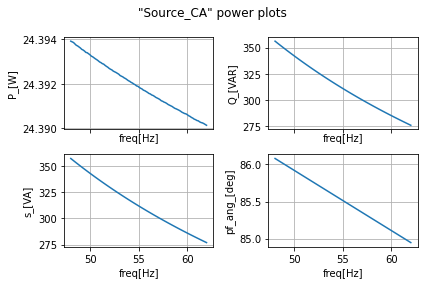

In [51]:
power_calcs_ac.autogen_powercalcs(ac_data_ABC, 'Source_CA')
power_calcs_ac.make_power_plot(ac_data_ABC, 'Source_CA')
ac_data_ABC.head()


# Three Phase Three Wire $\Delta$  Topology


Delta topologies are just weird, I have only had to work with them once when dealing with a 480V heater on an ancient giant diffusion pump. (if you don't know what a diffusion pump is just watch Applied Science's video on ["Giant glass diffusion pump and cathode ray tube demo"](https://youtu.be/SrNVLCHrJtY) )  ) The issue with them is that there is no neutral or ground. So because of that there being phased out when not needed. And there are ways to convert between them but to do it properly requires some specialty power engineering that is beyond this book. But for the analytical conversion see the YT videos by ALL ABOUT ELECTRONICS ["Star to Delta Conversion (With Proof and Example)"](https://youtu.be/9b17eqCT4-g) & ["Delta to Star Conversion (with proof and example)"](https://youtu.be/OV0qi7yzKAM).

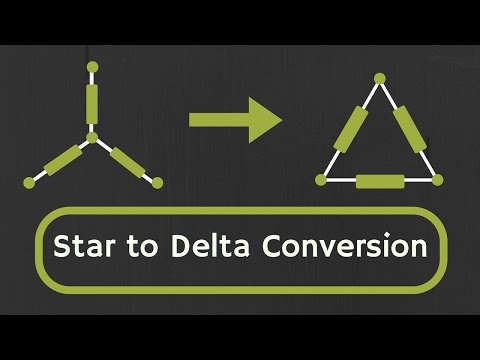

In [52]:
YouTubeVideo('9b17eqCT4-g', width=500, height=400)

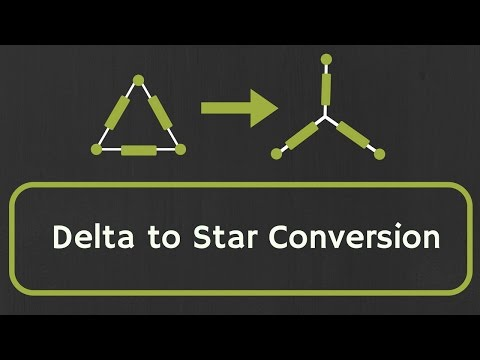

In [53]:
YouTubeVideo('OV0qi7yzKAM', width=500, height=400)

In recreating the Delta configuration in SPICE since there is no neutral or ground and SPICE requires one it can be a challenge to add one. One school of thought is to just add a ground to any of the phases. This not ideal since when measuring a Delta circuit in the wild the measurements are done between the phases and there is no ground involved. So instead we have opted to use the Delta circuit SPICE model employed by Alexander & Sadiki in their standard entry text "Fundamentals of Electric Circuits". This method of modeling hides the ground behind open resistors connected to each phase. This is a far more robust and more representative way of modeling a Delta circuit. On top of that zero Ohm resistors are added to each of the three phases negative terminal to avoid a loop error in SPICE.

In [54]:
#%%writefile -a AC_2_Codes.py
#chapteer 2 section1 three_phaseDelta_panel class
#class to create a SPICE model of a three-phase Delta source


class three_phaseDelta_panel:
    def __init__(self):
        pass
    
    @subcircuit
    def SKiDl_circ(self, Aterm_power, Bterm_power, Cterm_power):
        """
        SKiDl subcircuit of a primitive representation of a US 120 2 phase circuit
        panel with resistor separated ground from neutral and open from ground return
        
        Terminals:
            Aterm_power: terminal for the A phase to load 
            Bterm_power: terminal for the B phase to load 
            Cterm_power: terminal for the C phase to load 
            
        Returns:
            returns a SKiDl subcircuit. Some of the internal elements SkiDl objects
            are also stored in `self.panel_internals` which is a dictionary with 
            names for the objects as keys and the SkiDl object's elements as corresponding values
        """

        net_a=Net('a'); net_b=Net('b'); net_c=Net('c')
        
        #things connected to terminal a
        vs_ABphase=SINEV(ref='AB', ac_phase=0,  ac_magnitude=120@u_V)
        rabwire=R(ref='abwire', value=0@u_Ohm)
        ragnd_open=R(ref='aopen', value=1e16@u_Ohm)
        net_a & vs_ABphase['p', 'n'] & rabwire[1,2] & net_b
        net_a & ragnd_open[1, 2] & gnd
        
        #things connected to terminal b
        vs_BCphase=SINEV(ref='BC', ac_phase=np.deg2rad(-120),  ac_magnitude=120@u_V)
        rbcwire=R(ref='bcwire', value=0@u_Ohm)
        rbgnd_open=R(ref='bopen', value=1e16@u_Ohm)
        net_b & vs_BCphase['p', 'n'] & rbcwire[1,2] & net_c
        net_b & rbgnd_open[1, 2] & gnd
        
        #things connected to terminal c
        vs_CAphase=SINEV(ref='CA', ac_phase=np.deg2rad(120),  ac_magnitude=120@u_V)
        rcawire=R(ref='cawire', value=0@u_Ohm)
        rcgnd_open=R(ref='copen', value=1e16@u_Ohm)
        net_c & vs_CAphase['p', 'n'] & rcawire[1,2] & net_a
        net_c & rcgnd_open[1, 2] & gnd


        
        # make the connections to the rest of the circuit
        net_a+=Aterm_power
        net_b+=Bterm_power
        net_c+=Cterm_power
        
        
        
        
        
        #stowe away the elements to read from
        self.panel_internals={
                'ABPhase_Source':vs_ABphase,'BCPhase_Source': vs_BCphase, 'CAPhase_Source': vs_CAphase}
        
        
        
    
    def draw_me(self):
        """
        method to draw a representation of this subcircuit with 
        load representation with lcapy
        """
        schematic=kiwi.Circuit()
        
        schematic.add('W c1 c; right')
        schematic.add('W c2 c1; right')
        schematic.add('W c3 c2; right')
        schematic.add('W vc c3; down')
        schematic.add('Vca vc va; up, l=$120^{\circ}$')
        schematic.add('Rcawire va a3; up')
        schematic.add('W a3 a2; right')
        schematic.add('W a2 a1; right')
        schematic.add('W a1 a; right')
        
        schematic.add('Ragnd a2 0; down')
        schematic.add('Rcgnd c2 0; up')
        schematic.add('Rbgnd 0 b1; right')
        schematic.add('W 0 0_1; left=0.2, ground')

        schematic.add('Vab a1 vb; down, l=$0^{\circ}$')
        schematic.add('Rabwire vb b1; down')
        
        schematic.add('Vbc b1 vc1; down, l=$-120^{\circ}$')
        schematic.add('Rbcwire vc1 c1; down')
        
        schematic.add('W b1 b; right')

        
        schematic.draw()


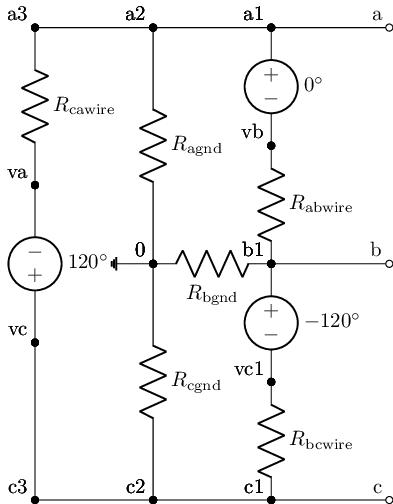

In [55]:
D3=three_phaseDelta_panel()
D3.draw_me()

In [56]:
reset()
net_A=Net('A_'); net_B=Net('B_'); net_C=Net('C_')

arm1=single_arm_mod.SKiDl_pack()
arm1wire=R(value=0@u_Ohm)
arm2=single_arm_mod.SKiDl_pack()
arm2wire=R(value=0@u_Ohm)
arm3=single_arm_mod.SKiDl_pack()
arm3wire=R(value=0@u_Ohm)

net_A & arm2wire[2, 1] & arm2['N', 'P'] & net_C & arm1wire[2, 1] & arm1['N', 'P'] & net_B & arm3wire[2, 1] & arm3['N', 'P'] & net_A




D3.SKiDl_circ(net_A, net_B, net_C)

circ=generate_netlist()
print(circ)

.title 
VAB a N_7 DC 0V AC 120V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)
VBC B_ N_8 DC 0V AC 120V -119.99999999999999rad SIN(0V 1V 50Hz 0s 0Hz)
VCA C_ N_9 DC 0V AC 120V 119.99999999999999rad SIN(0V 1V 50Hz 0s 0Hz)
L1 B_ N_10 0.10063694267515924H
L10 N_21 N_22 0.013821656050955413H
L11 N_20 N_6 0.10063694267515924H
L12 N_23 N_24 0.013821656050955413H
L2 N_11 N_12 0.013821656050955413H
L3 N_10 N_2 0.10063694267515924H
L4 N_13 N_14 0.013821656050955413H
L5 C_ N_15 0.10063694267515924H
L6 N_16 N_17 0.013821656050955413H
L7 N_15 N_4 0.10063694267515924H
L8 N_18 N_19 0.013821656050955413H
L9 a N_20 0.10063694267515924H
R1 N_2 C_ 0Ohm
R10 B_ N_11 0.8Ohm
R11 N_12 N_10 442.0Ohm
R12 N_10 N_13 0.8Ohm
R13 N_14 N_2 442.0Ohm
R14 C_ N_16 0.8Ohm
R15 N_17 N_15 442.0Ohm
R16 N_15 N_18 0.8Ohm
R17 N_19 N_4 442.0Ohm
R18 a N_21 0.8Ohm
R19 N_22 N_20 442.0Ohm
R2 N_4 a 0Ohm
R20 N_20 N_23 0.8Ohm
R21 N_24 N_6 442.0Ohm
R3 N_6 B_ 0Ohm
Rabwire N_7 B_ 0Ohm
Raopen a 0 1e+16Ohm
Rbcwire N_8 C_ 0Ohm
Rbopen B_ 0 1e+16Ohm
Rcawire N_9


3 warnings found during netlist generation.
0 errors found during netlist generation.



In [57]:
sim=circ.simulator()
ac_vals=sim.ac(start_frequency=48@u_Hz, stop_frequency=62@u_Hz, number_of_points=100, variation='lin')

In [58]:
D3.panel_internals

{'ABPhase_Source': 
  SINEV (sinev, SINUSOIDALVOLTAGE, sinusoidalvoltage): Sinusoidal voltage source
     Pin AB/1/p,anode,+,plus,A/PASSIVE
     Pin AB/2/n,m,C,cathode,-,minus,K,negative,neg/PASSIVE,
 'BCPhase_Source': 
  SINEV (sinev, SINUSOIDALVOLTAGE, sinusoidalvoltage): Sinusoidal voltage source
     Pin BC/1/p,anode,+,plus,A/PASSIVE
     Pin BC/2/n,m,C,cathode,-,minus,K,negative,neg/PASSIVE,
 'CAPhase_Source': 
  SINEV (sinev, SINUSOIDALVOLTAGE, sinusoidalvoltage): Sinusoidal voltage source
     Pin CA/1/p,anode,+,plus,A/PASSIVE
     Pin CA/2/n,m,C,cathode,-,minus,K,negative,neg/PASSIVE}

In [59]:
ac_data_base_df=pd.DataFrame(index=ac_vals.frequency.as_ndarray())
ac_data_base_df.index.name='freq[Hz]'

ac_data_base_df['SourceA_v_[V]']=ac_vals[node(D3.panel_internals['ABPhase_Source']['P'])].as_ndarray()
ac_data_base_df['SourceA_i_[A]']=-ac_vals[get_skidl_spice_ref(D3.panel_internals['ABPhase_Source'])].as_ndarray()

ac_data_base_df['SourceB_v_[V]']=ac_vals[node(D3.panel_internals['BCPhase_Source']['P'])].as_ndarray()
ac_data_base_df['SourceB_i_[A]']=-ac_vals[get_skidl_spice_ref(D3.panel_internals['BCPhase_Source'])].as_ndarray()

ac_data_base_df['SourceC_v_[V]']=ac_vals[node(D3.panel_internals['CAPhase_Source']['P'])].as_ndarray()
ac_data_base_df['SourceC_i_[A]']=-ac_vals[get_skidl_spice_ref(D3.panel_internals['CAPhase_Source'])].as_ndarray()


ac_data_base_df

,SourceA_v_[V],SourceA_i_[A],SourceB_v_[V],SourceB_i_[A],SourceC_v_[V],SourceC_i_[A]
freq[Hz],,,,,,
48.000000,60.031250-3.556649j,0.135554-1.978112j,-59.968613-3.558628j,-1.780872+0.871663j,0.029606+100.365295j,1.645318+1.106449j
48.141415,60.391308-34.311031j,0.135554-1.972309j,-59.608559-34.313004j,-1.775846+0.868761j,0.389666+69.610916j,1.640293+1.103547j
48.282829,60.010448-34.633430j,0.135553-1.966540j,-59.989414-34.635395j,-1.770850+0.865877j,0.008814+69.288521j,1.635297+1.100662j
48.424244,59.996464-34.664597j,0.135553-1.960804j,-60.003399-34.666557j,-1.765883+0.863010j,-0.005165+69.257355j,1.630330+1.097794j
48.565655,60.017643-34.689152j,0.135552-1.955102j,-59.982220-34.691109j,-1.760944+0.860159j,0.016018+69.232803j,1.625392+1.094943j
...,...,...,...,...,...,...
61.434345,59.996933-34.655178j,0.135521-1.546178j,-60.002930-34.656723j,-1.406790+0.655724j,-0.004336+69.266983j,1.271269+0.890454j
61.575756,79.058121-45.661934j,0.135521-1.542635j,-40.941746-45.663475j,-1.403721+0.653953j,19.056849+58.260227j,1.268200+0.888682j
61.717171,60.003307-34.609249j,0.135521-1.539107j,-59.996555-34.610790j,-1.400666+0.652189j,0.002043+69.312912j,1.265146+0.886918j


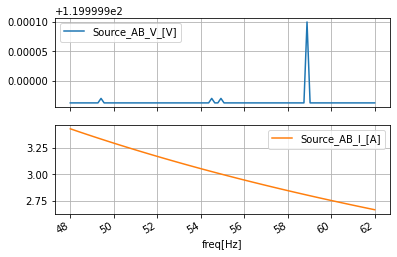

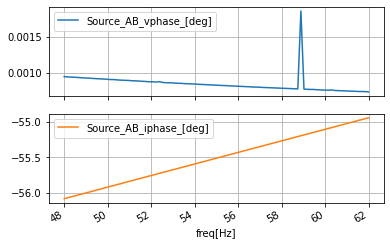

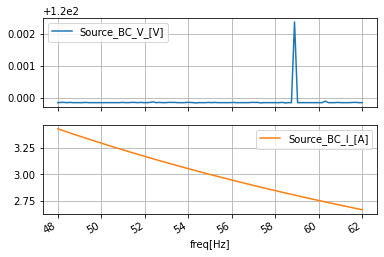

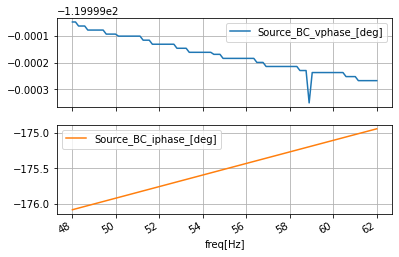

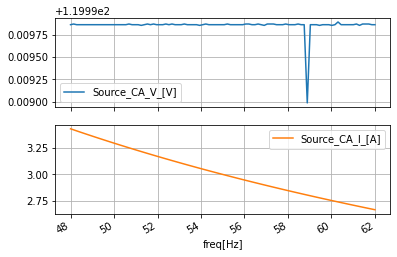

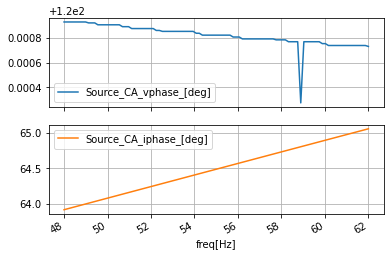

In [60]:
ac_data_ABC=ac_data_base_df.copy()

#AB voltage
ac_data_ABC['Source_AB_v_[V]']=ac_data_ABC['SourceA_v_[V]']-ac_data_ABC['SourceB_v_[V]']
ac_data_ABC['Source_AB_V_[V]']=np.abs(ac_data_ABC['Source_AB_v_[V]'])
ac_data_ABC['Source_AB_vphase_[deg]']=np.angle(ac_data_ABC['Source_AB_v_[V]'], True)

#AB current
ac_data_ABC['Source_AB_i_[A]']=ac_data_ABC['SourceA_i_[A]']-ac_data_ABC['SourceB_i_[A]']
ac_data_ABC['Source_AB_I_[A]']=np.abs(ac_data_ABC['Source_AB_i_[A]'])
ac_data_ABC['Source_AB_iphase_[deg]']=np.angle(ac_data_ABC['Source_AB_i_[A]'], True)

####################################################################################
#BC voltage
ac_data_ABC['Source_BC_v_[V]']=ac_data_ABC['SourceB_v_[V]']-ac_data_ABC['SourceC_v_[V]']
ac_data_ABC['Source_BC_V_[V]']=np.abs(ac_data_ABC['Source_BC_v_[V]'])
ac_data_ABC['Source_BC_vphase_[deg]']=np.angle(ac_data_ABC['Source_BC_v_[V]'], True)

#BC current
ac_data_ABC['Source_BC_i_[A]']=ac_data_ABC['SourceB_i_[A]']-ac_data_ABC['SourceC_i_[A]']
ac_data_ABC['Source_BC_I_[A]']=np.abs(ac_data_ABC['Source_BC_i_[A]'])
ac_data_ABC['Source_BC_iphase_[deg]']=np.angle(ac_data_ABC['Source_BC_i_[A]'], True)

####################################################################################
#CA voltage
ac_data_ABC['Source_CA_v_[V]']=ac_data_ABC['SourceC_v_[V]']-ac_data_ABC['SourceA_v_[V]']
ac_data_ABC['Source_CA_V_[V]']=np.abs(ac_data_ABC['Source_CA_v_[V]'])
ac_data_ABC['Source_CA_vphase_[deg]']=np.angle(ac_data_ABC['Source_CA_v_[V]'], True)

#CA current
ac_data_ABC['Source_CA_i_[A]']=ac_data_ABC['SourceC_i_[A]']-ac_data_ABC['SourceA_i_[A]']
ac_data_ABC['Source_CA_I_[A]']=np.abs(ac_data_ABC['Source_CA_i_[A]'])
ac_data_ABC['Source_CA_iphase_[deg]']=np.angle(ac_data_ABC['Source_CA_i_[A]'], True)

ac_data_ABC.plot(y=['Source_AB_V_[V]', 'Source_AB_I_[A]'], subplots=True, sharex=True, grid=True)
ac_data_ABC.plot(y=['Source_AB_vphase_[deg]', 'Source_AB_iphase_[deg]'], subplots=True, sharex=True, grid=True)

ac_data_ABC.plot(y=['Source_BC_V_[V]', 'Source_BC_I_[A]'], subplots=True, sharex=True, grid=True)
ac_data_ABC.plot(y=['Source_BC_vphase_[deg]', 'Source_BC_iphase_[deg]'], subplots=True, sharex=True, grid=True)

ac_data_ABC.plot(y=['Source_CA_V_[V]', 'Source_CA_I_[A]'], subplots=True, sharex=True, grid=True)
ac_data_ABC.plot(y=['Source_CA_vphase_[deg]', 'Source_CA_iphase_[deg]'], subplots=True, sharex=True, grid=True);

I don't understand why there is a bit of a spike in this simulation around 59Hz.

,SourceA_v_[V],SourceA_i_[A],SourceB_v_[V],SourceB_i_[A],SourceC_v_[V],SourceC_i_[A],Source_AB_v_[V],Source_AB_V_[V],Source_AB_vphase_[deg],Source_AB_i_[A],...,Source_CA_i_[A],Source_CA_I_[A],Source_CA_iphase_[deg],Source_AB_p_[W],Source_AB_P_[W],Source_AB_Q_[VAR],Source_AB_S_[VA],Source_AB_s_[VA],Source_AB_pf_[],Source_AB_pfang_[deg]
freq[Hz],,,,,,,,,,,,,,,,,,,,,
48.000000,60.031250-3.556649j,0.135554-1.978112j,-59.968613-3.558628j,-1.780872+0.871663j,0.029606+100.365295j,1.645318+1.106449j,119.999863+0.001978j,119.999863,0.000945,1.916427-2.849775j,...,1.509764+3.084561j,3.434226,63.920181,229.976562-341.968781j,114.982651,170.988174,114.982651+170.988174j,206.053314,0.558024,56.080757
48.141415,60.391308-34.311031j,0.135554-1.972309j,-59.608559-34.313004j,-1.775846+0.868761j,0.389666+69.610916j,1.640293+1.103547j,119.999863+0.001972j,119.999863,0.000942,1.911400-2.841070j,...,1.504739+3.075856j,3.424198,63.931671,229.373383-340.924255j,114.681091,170.465912,114.681091+170.465912j,205.451645,0.558190,56.069267
48.282829,60.010448-34.633430j,0.135553-1.966540j,-59.989414-34.635395j,-1.770850+0.865877j,0.008814+69.288521j,1.635297+1.100662j,119.999863+0.001965j,119.999863,0.000938,1.906403-2.832417j,...,1.499743+3.067202j,3.414229,63.943153,228.773712-339.885895j,114.381287,169.946701,114.381287+169.946701j,204.853516,0.558356,56.057785
48.424244,59.996464-34.664597j,0.135553-1.960804j,-60.003399-34.666557j,-1.765883+0.863010j,-0.005165+69.257355j,1.630330+1.097794j,119.999863+0.001961j,119.999863,0.000936,1.901436-2.823814j,...,1.494777+3.058599j,3.404318,63.954636,228.177551-338.853577j,114.083237,169.430511,114.083237+169.430511j,204.258865,0.558523,56.046295
48.565655,60.017643-34.689152j,0.135552-1.955102j,-59.982220-34.691109j,-1.760944+0.860159j,0.016018+69.232803j,1.625392+1.094943j,119.999863+0.001957j,119.999863,0.000934,1.896497-2.815262j,...,1.489840+3.050045j,3.394466,63.966122,227.584885-337.827271j,113.786934,168.917358,113.786934+168.917358j,203.667725,0.558689,56.034809


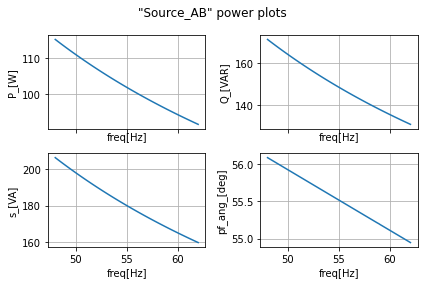

In [61]:
power_calcs_ac.autogen_powercalcs(ac_data_ABC, 'Source_AB')
power_calcs_ac.make_power_plot(ac_data_ABC, 'Source_AB')
ac_data_ABC.head()


,SourceA_v_[V],SourceA_i_[A],SourceB_v_[V],SourceB_i_[A],SourceC_v_[V],SourceC_i_[A],Source_AB_v_[V],Source_AB_V_[V],Source_AB_vphase_[deg],Source_AB_i_[A],...,Source_AB_s_[VA],Source_AB_pf_[],Source_AB_pfang_[deg],Source_BC_p_[W],Source_BC_P_[W],Source_BC_Q_[VAR],Source_BC_S_[VA],Source_BC_s_[VA],Source_BC_pf_[],Source_BC_pfang_[deg]
freq[Hz],,,,,,,,,,,,,,,,,,,,,
48.000000,60.031250-3.556649j,0.135554-1.978112j,-59.968613-3.558628j,-1.780872+0.871663j,0.029606+100.365295j,1.645318+1.106449j,119.999863+0.001978j,119.999863,0.000945,1.916427-2.849775j,...,206.053314,0.558024,56.080757,181.165359+370.149933j,114.982643,170.988174,114.982643+170.988174j,206.053299,0.558024,56.080757
48.141415,60.391308-34.311031j,0.135554-1.972309j,-59.608559-34.313004j,-1.775846+0.868761j,0.389666+69.610916j,1.640293+1.103547j,119.999863+0.001972j,119.999863,0.000942,1.911400-2.841070j,...,205.451645,0.558190,56.069267,180.562393+369.105316j,114.681084,170.465897,114.681084+170.465897j,205.451630,0.558190,56.069267
48.282829,60.010448-34.633430j,0.135553-1.966540j,-59.989414-34.635395j,-1.770850+0.865877j,0.008814+69.288521j,1.635297+1.100662j,119.999863+0.001965j,119.999863,0.000938,1.906403-2.832417j,...,204.853516,0.558356,56.057785,179.962967+368.066833j,114.381294,169.946716,114.381294+169.946716j,204.853531,0.558356,56.057785
48.424244,59.996464-34.664597j,0.135553-1.960804j,-60.003399-34.666557j,-1.765883+0.863010j,-0.005165+69.257355j,1.630330+1.097794j,119.999863+0.001961j,119.999863,0.000936,1.901436-2.823814j,...,204.258865,0.558523,56.046295,179.367020+367.034363j,114.083244,169.430511,114.083244+169.430511j,204.258865,0.558523,56.046288
48.565655,60.017643-34.689152j,0.135552-1.955102j,-59.982220-34.691109j,-1.760944+0.860159j,0.016018+69.232803j,1.625392+1.094943j,119.999863+0.001957j,119.999863,0.000934,1.896497-2.815262j,...,203.667725,0.558689,56.034809,178.774567+366.007935j,113.786926,168.917358,113.786926+168.917358j,203.667709,0.558689,56.034809


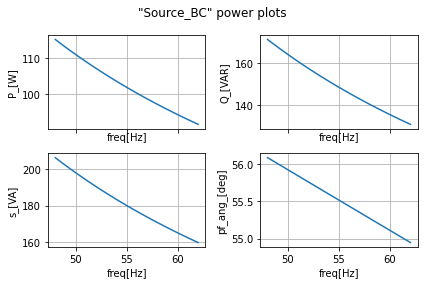

In [62]:
power_calcs_ac.autogen_powercalcs(ac_data_ABC, 'Source_BC')
power_calcs_ac.make_power_plot(ac_data_ABC, 'Source_BC')
ac_data_ABC.head()


,SourceA_v_[V],SourceA_i_[A],SourceB_v_[V],SourceB_i_[A],SourceC_v_[V],SourceC_i_[A],Source_AB_v_[V],Source_AB_V_[V],Source_AB_vphase_[deg],Source_AB_i_[A],...,Source_BC_s_[VA],Source_BC_pf_[],Source_BC_pfang_[deg],Source_CA_p_[W],Source_CA_P_[W],Source_CA_Q_[VAR],Source_CA_S_[VA],Source_CA_s_[VA],Source_CA_pf_[],Source_CA_pfang_[deg]
freq[Hz],,,,,,,,,,,,,,,,,,,,,
48.000000,60.031250-3.556649j,0.135554-1.978112j,-59.968613-3.558628j,-1.780872+0.871663j,0.029606+100.365295j,1.645318+1.106449j,119.999863+0.001978j,119.999863,0.000945,1.916427-2.849775j,...,206.053299,0.558024,56.080757,-411.141937-28.181152j,114.982651,170.988174,114.982651+170.988174j,206.053314,0.558024,56.080757
48.141415,60.391308-34.311031j,0.135554-1.972309j,-59.608559-34.313004j,-1.775846+0.868761j,0.389666+69.610916j,1.640293+1.103547j,119.999863+0.001972j,119.999863,0.000942,1.911400-2.841070j,...,205.451630,0.558190,56.069267,-409.935791-28.181015j,114.681091,170.465912,114.681091+170.465912j,205.451645,0.558190,56.069267
48.282829,60.010448-34.633430j,0.135553-1.966540j,-59.989414-34.635395j,-1.770850+0.865877j,0.008814+69.288521j,1.635297+1.100662j,119.999863+0.001965j,119.999863,0.000938,1.906403-2.832417j,...,204.853531,0.558356,56.057785,-408.736694-28.180878j,114.381287,169.946701,114.381287+169.946701j,204.853516,0.558356,56.057785
48.424244,59.996464-34.664597j,0.135553-1.960804j,-60.003399-34.666557j,-1.765883+0.863010j,-0.005165+69.257355j,1.630330+1.097794j,119.999863+0.001961j,119.999863,0.000936,1.901436-2.823814j,...,204.258865,0.558523,56.046288,-407.544586-28.180756j,114.083237,169.430511,114.083237+169.430511j,204.258865,0.558523,56.046295
48.565655,60.017643-34.689152j,0.135552-1.955102j,-59.982220-34.691109j,-1.760944+0.860159j,0.016018+69.232803j,1.625392+1.094943j,119.999863+0.001957j,119.999863,0.000934,1.896497-2.815262j,...,203.667709,0.558689,56.034809,-406.359467-28.180664j,113.786942,168.917358,113.786942+168.917358j,203.667725,0.558689,56.034809


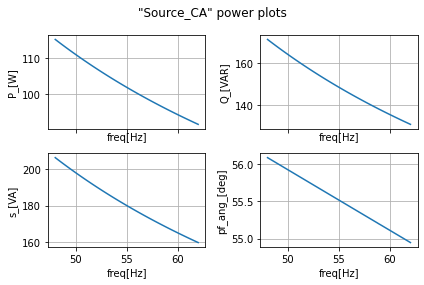

In [63]:
power_calcs_ac.autogen_powercalcs(ac_data_ABC, 'Source_CA')
power_calcs_ac.make_power_plot(ac_data_ABC, 'Source_CA')
ac_data_ABC.head()


## Citations:
[1] stackexchange Electrical Engineering. "Using a single phase induction motor equivalent circuit in LTspice," Stack Overflow Forum, July 30, 2019. Available: https://electronics.stackexchange.com/questions/234290/using-a-single-phase-induction-motor-equivalent-circuit-in-ltspice)

[2] ALL ABOUT ELECTRONICS. "RMS (Root Mean Square) Value and Average Value of AC Signals
" YouTube, Sep 24, 2017. [Video file]. Available: https://youtu.be/qDHsokTcgck. [Accessed: Dec 20, 2020].

[3] Makarov, S., Ludwig, R. and Bitar, S., 2016. Practical Electrical Engineering. 1st ed. Cham: Springer International Publishing, pp.564-566.

[4] ALL ABOUT ELECTRONICS. "What is Power Factor? What is Leading & Lagging Power factor ? Power Factor Correction Methods" YouTube, Nov 5, 2017. [Video file]. Available: https://youtu.be/iDYWfBGwT1w. [Accessed: Dec 20, 2020].

[5] Notaroš, B., 2011. Electromagnetics. Upper Saddle River: Prentice Hall, p.398.

[6] Technology Connections. "The US electrical system is not 120V" YouTube, Jun 22, 2020. [Video file]. Available: https://youtu.be/jMmUoZh3Hq4. [Accessed: Dec 20, 2020].

[7] Technology Connections. "The GFCI/RCD: A Simple but Life-Saving Protector" YouTube, Aug 17, 2018. [Video file]. Available: https://youtu.be/ILBjnZq0n8s. [Accessed: Dec 20, 2020].

[8] grayfurnaceman. "The difference between neutral and ground on the electric panel" YouTube, Jan 26, 2014. [Video file]. Available: https://youtu.be/-n8CiU_6KqE. [Accessed: Dec 20, 2020].

[9] ALL ABOUT ELECTRONICS. "Star to Delta Conversion (With Proof and Example)" YouTube, Mar 6, 2017. [Video file]. Available: https://youtu.be/9b17eqCT4-g. [Accessed: Dec 20, 2020].

[10] ALL ABOUT ELECTRONICS. "Delta to Star Conversion (with proof and example)" YouTube, Feb 28, 2017. [Video file]. Available: https://youtu.be/OV0qi7yzKAM. [Accessed: Dec 20, 2020].

[11] Alexander, C. and Sadiku, M., 2013. Fundamentals Of Electric Circuits. 5th ed. New York: McGraw-Hill, p.531.